In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import csv
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
from maxentpy import maxent

Using TensorFlow backend.


In [2]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
import os.path as op

In [4]:
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import splanl.junction_scorer as jn
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.inspect_variants as iv
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.create_vcf as vcf

In [7]:
chr11 = '/nfs/kitzman2/lab_common2/refs/human/ucsc_hg19/bychrom/chr11.fa'
chr11_seq = pp.get_refseq( chr11 )[ 'chr11' ]

In [8]:
isos_in = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [9]:
isos_df = pd.read_table( isos_in + 'wt1_ex9_isoforms_2022-0915.txt' )

In [10]:
isos_df = isos_df.set_index( 'isonum' )

In [11]:
bdout = isos_in

In [12]:
bam1 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_test*/*out.wbcs.bam

In [13]:
bam2 = ! ls /nfs/kitzman2/jacob/proj/jensplice/20220513_wt1_mpsa_trial4and3_deep_redoAligns/process_star/BB_RT*/*out.wbcs.bam

In [14]:
bam = bam1 + bam2

In [15]:
msamp_fn = { b.split( '/')[ -1 ].split( '.' )[ 0 ].replace( 'Aligned', '' ) : b for b in bam }

In [16]:
isogrpdict = { samp: jn.create_iso_dict_no_cnst( isos_df.query( samp + '_filter!=0' ) )
              for samp in msamp_fn }

In [17]:
isogrpdict_allsamp = { isonum: iso for samp in isogrpdict for isonum,iso in isogrpdict[ samp ].items() }

In [18]:
isogrpdict_allsamp

{'iso0054': ((1236, 1359),),
 'iso0217': ((1284, 1350),),
 'iso0723': ((1267, 1293), (1334, 1359)),
 'iso1347': ((1267, 1350),),
 'iso1566': ((1267, 1340), (2171, 2179)),
 'iso1702': ((1267, 1273), (1295, 1350)),
 'iso1849': ((1265, 1359),),
 'iso2297': ((1269, 1359),),
 'iso2343': ((1268, 1350),),
 'iso2615': ((1267, 1359),),
 'iso3877': ((1267, 1289), (1335, 1359)),
 'iso4295': ((1284, 1359),),
 'iso4729': (),
 'iso5505': ((1269, 1350),),
 'iso5899': ((1267, 1347),),
 'iso7208': ((1267, 1314), (1337, 1350)),
 'iso2368': ((1267, 1304), (1336, 1359)),
 'iso5789': ((1305, 1359),),
 'iso0970': ((1267, 1331),),
 'iso3689': ((1268, 1359),),
 'iso4864': ((1270, 1359),),
 'iso0528': ((1236, 1350),),
 'iso0651': ((955, 960), (1271, 1350)),
 'iso2311': ((1266, 1359),),
 'iso2529': ((1266, 1350),),
 'iso3943': ((1267, 1274), (1296, 1350)),
 'iso6265': ((1267, 1321), (1344, 1359)),
 'iso0062': ((1267, 1289), (1335, 1350)),
 'iso0332': ((1267, 1337), (2393, 2399)),
 'iso0402': ((1267, 1293), (133

In [19]:
len( isogrpdict_allsamp )

211

In [20]:
satbls = ! ls /nfs/turbo/umms-kitzmanj/oldvol2/jacob/proj/jensplice/20220426_wt1_subasm_filter_stringent/sapipe/sa/*.haps.final.txt

In [21]:
satbl_fn = { sa.split( '/')[ -1 ].split( '.' )[ 0 ]: pd.read_table( sa ).set_index( 'readgroupid' ) for sa in satbls }

In [22]:
for lib in satbl_fn.keys():
    
    satbl_fn[ lib ] = satbl_fn[ lib ][ [ col for col in satbl_fn[ lib ] if not col.startswith( 'nbp_' ) ] ].copy()

In [25]:
isonamedict = { 'KTS+': [ (1267, 1359) ],
                'KTS-': [ (1267, 1350) ],
                'SKIP': [] }

In [26]:
namedisogrps = { samp: jn.create_named_isogrps( isogrpdict_allsamp,
                                                isonamedict,
                                                [],
                                                28,
                                                150,
                                                3 )
                for samp in isogrpdict }

In [56]:
#now in junction scorer!
def process_bcs_wrapper( sample,
                         pysam_align,
                         all_isogrpdict,
                         named_isogrpdict,
                         cnst_exons,
                         satbl,
                         spl_tol = 3,
                         indel_tol = 20,
                         min_matches_for = 70,
                         min_matches_rev = 50,
                         tol_first_last = 0,
                         min_reads = 1,
                         other_isos_usable = False,
                         bc_tag = 'RX',
                         max_bc_len = 30,
                         unmapped_pysam = None,
                         unmap_bc_split_char = '_BC=',
                         unmap_col = 'unmapped_reads',
                         read_tot_col = 'num_reads',
                         usable_read_col = 'usable_reads',
                         other_cols = [ 'secondary_reads', 'unpaired_reads', 'bad_starts', 'bad_ends', 'soft_clipped', 'other_isoform' ],
                         waterfall_thresh = [ 75, 95 ],
                         bc_read_cut_thresh = 95 ):
    
    assert bc_read_cut_thresh in waterfall_thresh, 'BC read cut off thresholds must be a subset of waterfall thresholds!'
    
    t0 = time.time()
    
    print( 'Processing sample %s' % sample )
    
    msamp_bcrnatbl = jn.compute_isoform_counts_pe( pysam_align,
                                                   all_isogrpdict,
                                                   cnst_exons,
                                                   spl_tol = spl_tol,
                                                   indel_tol = indel_tol,
                                                   min_matches_for = min_matches_for,
                                                   min_matches_rev = min_matches_rev,
                                                   bc_tag = bc_tag )
    
    pysam_align.close()
    
    msamp_bcrnatbl_flen = jn.filter_on_barc_len( msamp_bcrnatbl, 
                                                 max_len = max_bc_len )
    
    if unmapped_pysam:
    
        msamp_bcrnatbl_flen = jn.merge_unmapped_bcs( msamp_bcrnatbl_flen,
                                                     unmapped_pysam,
                                                     bc_split_char = unmap_bc_split_char,
                                                     unmap_col = unmap_col,
                                                     read_tot_col = read_tot_col )
    
    msamp_bcrnatbl_rename = jn.combine_isogrps_pe( named_isogrpdict,
                                                   msamp_bcrnatbl_flen,
                                                   keep_cols = [ read_tot_col, usable_read_col, unmap_col ] + other_cols  ) 
        
    msamp_varbcrnatbl_flen_allisos = mbcs.merge_subasm_and_rna_tbls( satbl,
                                                                     msamp_bcrnatbl_flen )
    
    x_cuts,y_cuts = sp.waterfall_plot( msamp_bcrnatbl_flen,
                                       usable_read_col,
                                       waterfall_thresh )
    
    cut_d = { 'x': x_cuts, 'y': y_cuts }
    
    msamp_byvartbl_allisos = mbcs.summarize_byvar_singlevaronly_pe( satbl,
                                                                    msamp_bcrnatbl_flen,
                                                                    cut_d[ 'y' ][ bc_read_cut_thresh ],
                                                                    [ usable_read_col, unmap_col ] + other_cols )
    
    t1 = time.time()
    
    print( 'Finished processing sample %s in %.2f minutes' % ( sample, ( t1 - t0 ) / 60 ) )
    
    return { 'msamp_bcrnatbl_rename': msamp_bcrnatbl_rename,
             'msamp_varbcrnatbl_flen_allisos': msamp_varbcrnatbl_flen_allisos,
             'msamp_byvartbl_allisos': msamp_byvartbl_allisos,
             'bc_read_cutoffs': cut_d }

In [57]:
msamp_rnabam = { samp: pysam.AlignmentFile(msamp_fn[samp],'rb') for samp in msamp_fn }

In [58]:
unmap_mate1_fn = { samp: pysam.FastxFile( file.replace( 'Aligned.out.wbcs.bam', 'Unmapped.out.mate1' ) )
                   for samp,file in msamp_fn.items() }

Processing sample BB_test_Cos1053_JKLab0340_MM1B
processed 1000 bcs, 31955 reads
processed 2000 bcs, 67678 reads
processed 3000 bcs, 104625 reads
processed 4000 bcs, 135250 reads
processed 5000 bcs, 175518 reads
processed 6000 bcs, 207177 reads
processed 7000 bcs, 238942 reads
processed 8000 bcs, 271519 reads
processed 9000 bcs, 303319 reads
processed 10000 bcs, 331774 reads
processed 11000 bcs, 365298 reads
processed 12000 bcs, 396164 reads
processed 13000 bcs, 430813 reads
processed 14000 bcs, 466631 reads
processed 15000 bcs, 504354 reads
processed 16000 bcs, 540229 reads
processed 17000 bcs, 571677 reads
processed 18000 bcs, 602486 reads
processed 19000 bcs, 632954 reads
processed 20000 bcs, 662173 reads
processed 21000 bcs, 694710 reads
processed 22000 bcs, 728389 reads
processed 23000 bcs, 764562 reads
processed 24000 bcs, 794577 reads
processed 25000 bcs, 823749 reads
processed 26000 bcs, 853002 reads
processed 27000 bcs, 883973 reads
processed 28000 bcs, 923132 reads
processed 

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


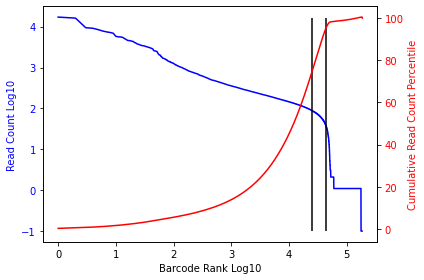

The read count cut off at the 75 th percentile is 87
The read count cut off at the 95 th percentile is 38
Finished processing sample BB_test_Cos1053_JKLab0340_MM1B
Processing sample BB_test_Cos1053_JKLab0340_MM2B
processed 1000 bcs, 40859 reads
processed 2000 bcs, 84153 reads
processed 3000 bcs, 123015 reads
processed 4000 bcs, 175870 reads
processed 5000 bcs, 217158 reads
processed 6000 bcs, 258563 reads
processed 7000 bcs, 308884 reads
processed 8000 bcs, 353052 reads
processed 9000 bcs, 399862 reads
processed 10000 bcs, 436994 reads
processed 11000 bcs, 474859 reads
processed 12000 bcs, 511667 reads
processed 13000 bcs, 554535 reads
processed 14000 bcs, 595407 reads
processed 15000 bcs, 629651 reads
processed 16000 bcs, 664453 reads
processed 17000 bcs, 712805 reads
processed 18000 bcs, 748690 reads
processed 19000 bcs, 787704 reads
processed 20000 bcs, 844871 reads
processed 21000 bcs, 878779 reads
processed 22000 bcs, 926859 reads
processed 23000 bcs, 969933 reads
processed 24000 

processed 227000 bcs, 9123691 reads
processed 228000 bcs, 9165944 reads
processed 229000 bcs, 9207394 reads
processed 230000 bcs, 9249250 reads
processed 231000 bcs, 9288331 reads
processed 232000 bcs, 9323209 reads
processed 233000 bcs, 9366049 reads
processed 234000 bcs, 9403531 reads
processed 235000 bcs, 9450105 reads
processed 236000 bcs, 9490332 reads
processed 237000 bcs, 9540205 reads
processed 238000 bcs, 9591876 reads
processed 239000 bcs, 9627266 reads
processed 240000 bcs, 9664867 reads
processed 241000 bcs, 9698665 reads
processed 242000 bcs, 9735905 reads
processed 243000 bcs, 9770316 reads
processed 244000 bcs, 9803938 reads
processed 245000 bcs, 9835293 reads
processed 246000 bcs, 9873431 reads
processed 247000 bcs, 9908934 reads
processed 248000 bcs, 9960283 reads
processed 249000 bcs, 9998149 reads
processed 250000 bcs, 10039268 reads
processed 251000 bcs, 10078197 reads
processed 252000 bcs, 10114265 reads
processed 253000 bcs, 10152677 reads
processed 254000 bcs, 10

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


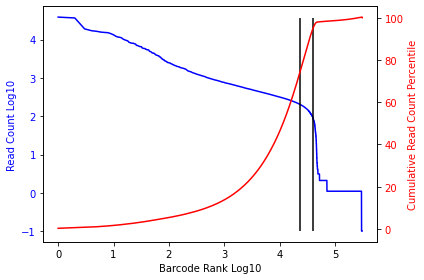

The read count cut off at the 75 th percentile is 200
The read count cut off at the 95 th percentile is 89
Finished processing sample BB_test_Cos1053_JKLab0340_MM2B
Processing sample BB_test_Cos1053_oligodT_MM1B
processed 1000 bcs, 28596 reads
processed 2000 bcs, 57690 reads
processed 3000 bcs, 92683 reads
processed 4000 bcs, 123293 reads
processed 5000 bcs, 153023 reads
processed 6000 bcs, 181131 reads
processed 7000 bcs, 209815 reads
processed 8000 bcs, 237974 reads
processed 9000 bcs, 265970 reads
processed 10000 bcs, 290592 reads
processed 11000 bcs, 320808 reads
processed 12000 bcs, 347352 reads
processed 13000 bcs, 380495 reads
processed 14000 bcs, 410836 reads
processed 15000 bcs, 442072 reads
processed 16000 bcs, 472393 reads
processed 17000 bcs, 498694 reads
processed 18000 bcs, 524855 reads
processed 19000 bcs, 553119 reads
processed 20000 bcs, 580174 reads
processed 21000 bcs, 608328 reads
processed 22000 bcs, 636400 reads
processed 23000 bcs, 664080 reads
processed 24000 bc

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


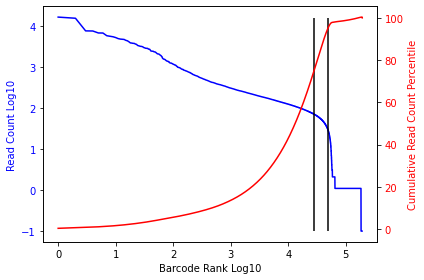

The read count cut off at the 75 th percentile is 71
The read count cut off at the 95 th percentile is 30
Finished processing sample BB_test_Cos1053_oligodT_MM1B
Processing sample BB_test_Cos1053_oligodT_MM2B
processed 1000 bcs, 35168 reads
processed 2000 bcs, 75461 reads
processed 3000 bcs, 120523 reads
processed 4000 bcs, 157958 reads
processed 5000 bcs, 208340 reads
processed 6000 bcs, 241302 reads
processed 7000 bcs, 281265 reads
processed 8000 bcs, 319136 reads
processed 9000 bcs, 370242 reads
processed 10000 bcs, 410620 reads
processed 11000 bcs, 451785 reads
processed 12000 bcs, 494853 reads
processed 13000 bcs, 533429 reads
processed 14000 bcs, 572516 reads
processed 15000 bcs, 610894 reads
processed 16000 bcs, 644642 reads
processed 17000 bcs, 684113 reads
processed 18000 bcs, 721415 reads
processed 19000 bcs, 760106 reads
processed 20000 bcs, 793042 reads
processed 21000 bcs, 824260 reads
processed 22000 bcs, 856629 reads
processed 23000 bcs, 908326 reads
processed 24000 bcs,

processed 227000 bcs, 8463261 reads
processed 228000 bcs, 8503184 reads
processed 229000 bcs, 8539239 reads
processed 230000 bcs, 8569251 reads
processed 231000 bcs, 8605046 reads
processed 232000 bcs, 8638341 reads
processed 233000 bcs, 8676648 reads
processed 234000 bcs, 8708033 reads
processed 235000 bcs, 8740633 reads
processed 236000 bcs, 8771705 reads
processed 237000 bcs, 8815144 reads
processed 238000 bcs, 8846300 reads
processed 239000 bcs, 8878960 reads
processed 240000 bcs, 8912449 reads
processed 241000 bcs, 8945714 reads
processed 242000 bcs, 8984001 reads
processed 243000 bcs, 9015990 reads
processed 244000 bcs, 9052440 reads
processed 245000 bcs, 9122829 reads
processed 246000 bcs, 9157737 reads
processed 247000 bcs, 9189153 reads
processed 248000 bcs, 9219563 reads
processed 249000 bcs, 9257866 reads
processed 250000 bcs, 9289470 reads
processed 251000 bcs, 9323891 reads
processed 252000 bcs, 9377115 reads
processed 253000 bcs, 9416331 reads
processed 254000 bcs, 945228

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


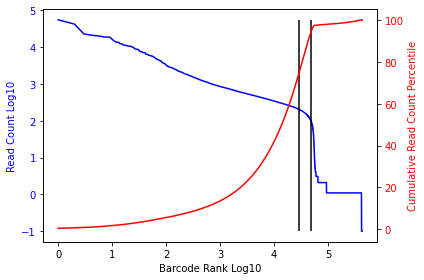

The read count cut off at the 75 th percentile is 203
The read count cut off at the 95 th percentile is 92
Finished processing sample BB_test_Cos1053_oligodT_MM2B
Processing sample BB_RT_1_340_243_Cos1053
processed 1000 bcs, 19851 reads
processed 2000 bcs, 40436 reads
processed 3000 bcs, 59204 reads
processed 4000 bcs, 77950 reads
processed 5000 bcs, 98318 reads
processed 6000 bcs, 117846 reads
processed 7000 bcs, 137868 reads
processed 8000 bcs, 157595 reads
processed 9000 bcs, 178232 reads
processed 10000 bcs, 197582 reads
processed 11000 bcs, 218829 reads
processed 12000 bcs, 239835 reads
processed 13000 bcs, 258921 reads
processed 14000 bcs, 277171 reads
processed 15000 bcs, 295042 reads
processed 16000 bcs, 315018 reads
processed 17000 bcs, 338804 reads
processed 18000 bcs, 360660 reads
processed 19000 bcs, 382265 reads
processed 20000 bcs, 403580 reads
processed 21000 bcs, 421612 reads
processed 22000 bcs, 440374 reads
processed 23000 bcs, 460527 reads
processed 24000 bcs, 481061

processed 228000 bcs, 4509240 reads
processed 229000 bcs, 4528963 reads
processed 230000 bcs, 4549495 reads
processed 231000 bcs, 4569200 reads
processed 232000 bcs, 4586614 reads
processed 233000 bcs, 4606633 reads
processed 234000 bcs, 4630100 reads
processed 235000 bcs, 4650938 reads
processed 236000 bcs, 4669365 reads
processed 237000 bcs, 4688600 reads
processed 238000 bcs, 4707098 reads
processed 239000 bcs, 4725496 reads
processed 240000 bcs, 4743227 reads
processed 241000 bcs, 4759684 reads
processed 242000 bcs, 4778176 reads
processed 243000 bcs, 4796555 reads
processed 244000 bcs, 4813915 reads
processed 245000 bcs, 4832683 reads
processed 246000 bcs, 4852081 reads
processed 247000 bcs, 4869291 reads
processed 248000 bcs, 4885818 reads
processed 249000 bcs, 4901819 reads
0 columns will be removed during this process.
Columns:  []


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


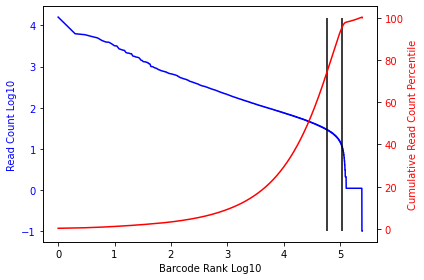

The read count cut off at the 75 th percentile is 29
The read count cut off at the 95 th percentile is 12
Finished processing sample BB_RT_1_340_243_Cos1053
Processing sample BB_RT_1_340_243_Hek1053
processed 1000 bcs, 10147 reads
processed 2000 bcs, 19988 reads
processed 3000 bcs, 31050 reads
processed 4000 bcs, 41801 reads
processed 5000 bcs, 53474 reads
processed 6000 bcs, 63875 reads
processed 7000 bcs, 74018 reads
processed 8000 bcs, 84058 reads
processed 9000 bcs, 94142 reads
processed 10000 bcs, 104040 reads
processed 11000 bcs, 114696 reads
processed 12000 bcs, 125148 reads
processed 13000 bcs, 137578 reads
processed 14000 bcs, 149803 reads
processed 15000 bcs, 160961 reads
processed 16000 bcs, 170843 reads
processed 17000 bcs, 181770 reads
processed 18000 bcs, 193303 reads
processed 19000 bcs, 204545 reads
processed 20000 bcs, 215405 reads
processed 21000 bcs, 226866 reads
processed 22000 bcs, 238772 reads
processed 23000 bcs, 251070 reads
processed 24000 bcs, 262204 reads
pro

processed 229000 bcs, 2390272 reads
processed 230000 bcs, 2400829 reads
processed 231000 bcs, 2412221 reads
processed 232000 bcs, 2423038 reads
processed 233000 bcs, 2433466 reads
processed 234000 bcs, 2443334 reads
processed 235000 bcs, 2454065 reads
processed 236000 bcs, 2464867 reads
processed 237000 bcs, 2475644 reads
processed 238000 bcs, 2487753 reads
processed 239000 bcs, 2498560 reads
processed 240000 bcs, 2509678 reads
processed 241000 bcs, 2520912 reads
processed 242000 bcs, 2532063 reads
processed 243000 bcs, 2543991 reads
processed 244000 bcs, 2555034 reads
processed 245000 bcs, 2564235 reads
processed 246000 bcs, 2573997 reads
processed 247000 bcs, 2583412 reads
processed 248000 bcs, 2592497 reads
processed 249000 bcs, 2602019 reads
processed 250000 bcs, 2612450 reads
processed 251000 bcs, 2624140 reads
processed 252000 bcs, 2635010 reads
processed 253000 bcs, 2645184 reads
processed 254000 bcs, 2654151 reads
processed 255000 bcs, 2663841 reads
processed 256000 bcs, 267307

processed 457000 bcs, 4922380 reads
processed 458000 bcs, 4930255 reads
processed 459000 bcs, 4938189 reads
processed 460000 bcs, 4948238 reads
processed 461000 bcs, 4957074 reads
processed 462000 bcs, 4966059 reads
processed 463000 bcs, 4974524 reads
processed 464000 bcs, 4985667 reads
processed 465000 bcs, 4995972 reads
processed 466000 bcs, 5006014 reads
processed 467000 bcs, 5016818 reads
processed 468000 bcs, 5027944 reads
processed 469000 bcs, 5039088 reads
processed 470000 bcs, 5050342 reads
processed 471000 bcs, 5060775 reads
processed 472000 bcs, 5071907 reads
processed 473000 bcs, 5082739 reads
processed 474000 bcs, 5093351 reads
processed 475000 bcs, 5103890 reads
processed 476000 bcs, 5113923 reads
processed 477000 bcs, 5123740 reads
processed 478000 bcs, 5136095 reads
processed 479000 bcs, 5148204 reads
processed 480000 bcs, 5159293 reads
processed 481000 bcs, 5169039 reads
processed 482000 bcs, 5180513 reads
processed 483000 bcs, 5192127 reads
processed 484000 bcs, 520455

processed 685000 bcs, 7261453 reads
processed 686000 bcs, 7269720 reads
processed 687000 bcs, 7278089 reads
processed 688000 bcs, 7287184 reads
processed 689000 bcs, 7297317 reads
processed 690000 bcs, 7307181 reads
processed 691000 bcs, 7316350 reads
processed 692000 bcs, 7327578 reads
processed 693000 bcs, 7338061 reads
processed 694000 bcs, 7348846 reads
processed 695000 bcs, 7359841 reads
processed 696000 bcs, 7369190 reads
processed 697000 bcs, 7378398 reads
processed 698000 bcs, 7387674 reads
processed 699000 bcs, 7396861 reads
processed 700000 bcs, 7406607 reads
processed 701000 bcs, 7414971 reads
processed 702000 bcs, 7426311 reads
processed 703000 bcs, 7436016 reads
processed 704000 bcs, 7447179 reads
processed 705000 bcs, 7457939 reads
processed 706000 bcs, 7466838 reads
processed 707000 bcs, 7476026 reads
processed 708000 bcs, 7486523 reads
processed 709000 bcs, 7494828 reads
processed 710000 bcs, 7502969 reads
processed 711000 bcs, 7512247 reads
processed 712000 bcs, 752256

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


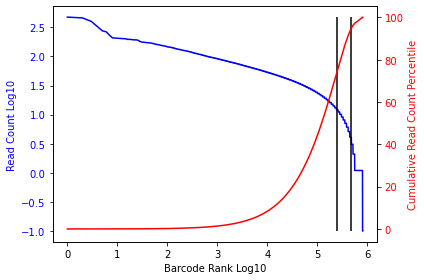

The read count cut off at the 75 th percentile is 12
The read count cut off at the 95 th percentile is 3
Finished processing sample BB_RT_1_340_243_Hek1053
Processing sample BB_RT_1_340_335_Cos1053
processed 1000 bcs, 28489 reads
processed 2000 bcs, 56480 reads
processed 3000 bcs, 86123 reads
processed 4000 bcs, 110066 reads
processed 5000 bcs, 137155 reads
processed 6000 bcs, 167265 reads
processed 7000 bcs, 195371 reads
processed 8000 bcs, 220524 reads
processed 9000 bcs, 247965 reads
processed 10000 bcs, 276085 reads
processed 11000 bcs, 325405 reads
processed 12000 bcs, 354232 reads
processed 13000 bcs, 386489 reads
processed 14000 bcs, 411842 reads
processed 15000 bcs, 441259 reads
processed 16000 bcs, 472319 reads
processed 17000 bcs, 499764 reads
processed 18000 bcs, 527932 reads
processed 19000 bcs, 553361 reads
processed 20000 bcs, 582903 reads
processed 21000 bcs, 608606 reads
processed 22000 bcs, 636932 reads
processed 23000 bcs, 662693 reads
processed 24000 bcs, 686161 read

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


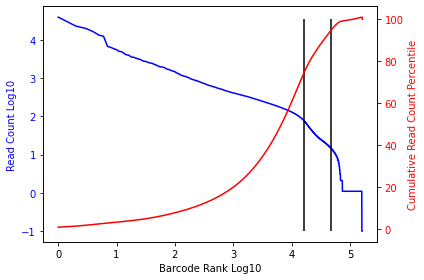

The read count cut off at the 75 th percentile is 74
The read count cut off at the 95 th percentile is 14
Finished processing sample BB_RT_1_340_335_Cos1053
Processing sample BB_RT_1_340_335_Hek1053
processed 1000 bcs, 10277 reads
processed 2000 bcs, 20599 reads
processed 3000 bcs, 33648 reads
processed 4000 bcs, 45476 reads
processed 5000 bcs, 55952 reads
processed 6000 bcs, 66559 reads
processed 7000 bcs, 77421 reads
processed 8000 bcs, 88981 reads
processed 9000 bcs, 100230 reads
processed 10000 bcs, 113583 reads
processed 11000 bcs, 126814 reads
processed 12000 bcs, 140018 reads
processed 13000 bcs, 152189 reads
processed 14000 bcs, 165166 reads
processed 15000 bcs, 176558 reads
processed 16000 bcs, 189003 reads
processed 17000 bcs, 200799 reads
processed 18000 bcs, 212769 reads
processed 19000 bcs, 222064 reads
processed 20000 bcs, 233213 reads
processed 21000 bcs, 245178 reads
processed 22000 bcs, 255996 reads
processed 23000 bcs, 265643 reads
processed 24000 bcs, 275697 reads
pr

processed 229000 bcs, 2639345 reads
processed 230000 bcs, 2651371 reads
processed 231000 bcs, 2664058 reads
processed 232000 bcs, 2677674 reads
processed 233000 bcs, 2689191 reads
processed 234000 bcs, 2703711 reads
processed 235000 bcs, 2716809 reads
processed 236000 bcs, 2730890 reads
processed 237000 bcs, 2743291 reads
processed 238000 bcs, 2755686 reads
processed 239000 bcs, 2766974 reads
processed 240000 bcs, 2780433 reads
processed 241000 bcs, 2793679 reads
processed 242000 bcs, 2805917 reads
processed 243000 bcs, 2817203 reads
processed 244000 bcs, 2830287 reads
processed 245000 bcs, 2841887 reads
processed 246000 bcs, 2854796 reads
processed 247000 bcs, 2868435 reads
processed 248000 bcs, 2882660 reads
processed 249000 bcs, 2899050 reads
processed 250000 bcs, 2915453 reads
processed 251000 bcs, 2927930 reads
processed 252000 bcs, 2939127 reads
processed 253000 bcs, 2952262 reads
processed 254000 bcs, 2968374 reads
processed 255000 bcs, 2981072 reads
processed 256000 bcs, 299324

processed 457000 bcs, 5477954 reads
processed 458000 bcs, 5490673 reads
processed 459000 bcs, 5502228 reads
processed 460000 bcs, 5513818 reads
processed 461000 bcs, 5524172 reads
processed 462000 bcs, 5536428 reads
processed 463000 bcs, 5549341 reads
processed 464000 bcs, 5561307 reads
processed 465000 bcs, 5572290 reads
processed 466000 bcs, 5584131 reads
processed 467000 bcs, 5597218 reads
processed 468000 bcs, 5611548 reads
processed 469000 bcs, 5627225 reads
processed 470000 bcs, 5642198 reads
processed 471000 bcs, 5656855 reads
processed 472000 bcs, 5670172 reads
processed 473000 bcs, 5684108 reads
processed 474000 bcs, 5697212 reads
processed 475000 bcs, 5711547 reads
processed 476000 bcs, 5723114 reads
processed 477000 bcs, 5734489 reads
processed 478000 bcs, 5745413 reads
processed 479000 bcs, 5758825 reads
processed 480000 bcs, 5769125 reads
processed 481000 bcs, 5780943 reads
processed 482000 bcs, 5792534 reads
processed 483000 bcs, 5803757 reads
processed 484000 bcs, 581492

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


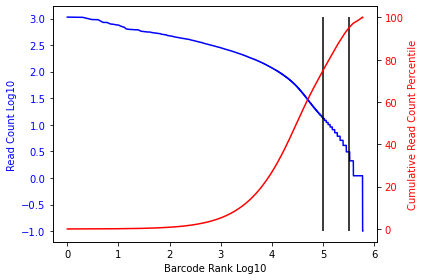

The read count cut off at the 75 th percentile is 13
The read count cut off at the 95 th percentile is 3
Finished processing sample BB_RT_1_340_335_Hek1053
Processing sample BB_RT_1b_340_243_Hek1053
processed 1000 bcs, 7660 reads
processed 2000 bcs, 15556 reads
processed 3000 bcs, 23363 reads
processed 4000 bcs, 31938 reads
processed 5000 bcs, 40214 reads
processed 6000 bcs, 49067 reads
processed 7000 bcs, 56968 reads
processed 8000 bcs, 64768 reads
processed 9000 bcs, 72286 reads
processed 10000 bcs, 80385 reads
processed 11000 bcs, 88076 reads
processed 12000 bcs, 95476 reads
processed 13000 bcs, 103192 reads
processed 14000 bcs, 110925 reads
processed 15000 bcs, 119767 reads
processed 16000 bcs, 128577 reads
processed 17000 bcs, 137164 reads
processed 18000 bcs, 145384 reads
processed 19000 bcs, 153311 reads
processed 20000 bcs, 160864 reads
processed 21000 bcs, 169380 reads
processed 22000 bcs, 178033 reads
processed 23000 bcs, 186258 reads
processed 24000 bcs, 194611 reads
process

processed 230000 bcs, 1863184 reads
processed 231000 bcs, 1870892 reads
processed 232000 bcs, 1877291 reads
processed 233000 bcs, 1884719 reads
processed 234000 bcs, 1892874 reads
processed 235000 bcs, 1901105 reads
processed 236000 bcs, 1908334 reads
processed 237000 bcs, 1915305 reads
processed 238000 bcs, 1922976 reads
processed 239000 bcs, 1930757 reads
processed 240000 bcs, 1937908 reads
processed 241000 bcs, 1945204 reads
processed 242000 bcs, 1952917 reads
processed 243000 bcs, 1960987 reads
processed 244000 bcs, 1968685 reads
processed 245000 bcs, 1974804 reads
processed 246000 bcs, 1980754 reads
processed 247000 bcs, 1988107 reads
processed 248000 bcs, 1995223 reads
processed 249000 bcs, 2003871 reads
processed 250000 bcs, 2012145 reads
processed 251000 bcs, 2018980 reads
processed 252000 bcs, 2025998 reads
processed 253000 bcs, 2033691 reads
processed 254000 bcs, 2040540 reads
processed 255000 bcs, 2048071 reads
processed 256000 bcs, 2054846 reads
processed 257000 bcs, 206260

processed 458000 bcs, 3786083 reads
processed 459000 bcs, 3795497 reads
processed 460000 bcs, 3805360 reads
processed 461000 bcs, 3815616 reads
processed 462000 bcs, 3825232 reads
processed 463000 bcs, 3834714 reads
processed 464000 bcs, 3843402 reads
processed 465000 bcs, 3853165 reads
processed 466000 bcs, 3861924 reads
processed 467000 bcs, 3870903 reads
processed 468000 bcs, 3881042 reads
processed 469000 bcs, 3890625 reads
processed 470000 bcs, 3899649 reads
processed 471000 bcs, 3908963 reads
processed 472000 bcs, 3917898 reads
processed 473000 bcs, 3927522 reads
processed 474000 bcs, 3936748 reads
processed 475000 bcs, 3946331 reads
processed 476000 bcs, 3955734 reads
processed 477000 bcs, 3964768 reads
processed 478000 bcs, 3972589 reads
processed 479000 bcs, 3980596 reads
processed 480000 bcs, 3988039 reads
processed 481000 bcs, 3995441 reads
processed 482000 bcs, 4003203 reads
processed 483000 bcs, 4011535 reads
processed 484000 bcs, 4019645 reads
processed 485000 bcs, 402796

processed 687000 bcs, 5614730 reads
processed 688000 bcs, 5620572 reads
processed 689000 bcs, 5629513 reads
processed 690000 bcs, 5638890 reads
processed 691000 bcs, 5647805 reads
processed 692000 bcs, 5656752 reads
processed 693000 bcs, 5665566 reads
processed 694000 bcs, 5674632 reads
processed 695000 bcs, 5682772 reads
processed 696000 bcs, 5690430 reads
processed 697000 bcs, 5698896 reads
processed 698000 bcs, 5707058 reads
processed 699000 bcs, 5714919 reads
processed 700000 bcs, 5723072 reads
processed 701000 bcs, 5731268 reads
processed 702000 bcs, 5739943 reads
processed 703000 bcs, 5748615 reads
processed 704000 bcs, 5757797 reads
processed 705000 bcs, 5766954 reads
processed 706000 bcs, 5774807 reads
processed 707000 bcs, 5783173 reads
processed 708000 bcs, 5791551 reads
processed 709000 bcs, 5800770 reads
processed 710000 bcs, 5810226 reads
processed 711000 bcs, 5819255 reads
processed 712000 bcs, 5829434 reads
processed 713000 bcs, 5838793 reads
processed 714000 bcs, 584832

processed 916000 bcs, 7440930 reads
processed 917000 bcs, 7447488 reads
processed 918000 bcs, 7454269 reads
processed 919000 bcs, 7461525 reads
processed 920000 bcs, 7469054 reads
processed 921000 bcs, 7476709 reads
processed 922000 bcs, 7483408 reads
processed 923000 bcs, 7490255 reads
processed 924000 bcs, 7496674 reads
processed 925000 bcs, 7503675 reads
processed 926000 bcs, 7509258 reads
0 columns will be removed during this process.
Columns:  []


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


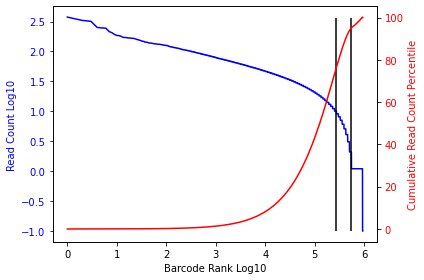

The read count cut off at the 75 th percentile is 10
The read count cut off at the 95 th percentile is 2
Finished processing sample BB_RT_1b_340_243_Hek1053
Processing sample BB_RT_1b_340_335_Hek1053
processed 1000 bcs, 10212 reads
processed 2000 bcs, 20633 reads
processed 3000 bcs, 32399 reads
processed 4000 bcs, 43995 reads
processed 5000 bcs, 54823 reads
processed 6000 bcs, 65144 reads
processed 7000 bcs, 74958 reads
processed 8000 bcs, 85935 reads
processed 9000 bcs, 98392 reads
processed 10000 bcs, 111824 reads
processed 11000 bcs, 124017 reads
processed 12000 bcs, 135070 reads
processed 13000 bcs, 146129 reads
processed 14000 bcs, 157028 reads
processed 15000 bcs, 168476 reads
processed 16000 bcs, 180018 reads
processed 17000 bcs, 191105 reads
processed 18000 bcs, 201001 reads
processed 19000 bcs, 212909 reads
processed 20000 bcs, 223964 reads
processed 21000 bcs, 234877 reads
processed 22000 bcs, 243762 reads
processed 23000 bcs, 253267 reads
processed 24000 bcs, 263982 reads
pr

processed 229000 bcs, 2553166 reads
processed 230000 bcs, 2563854 reads
processed 231000 bcs, 2576682 reads
processed 232000 bcs, 2587028 reads
processed 233000 bcs, 2599572 reads
processed 234000 bcs, 2611820 reads
processed 235000 bcs, 2625634 reads
processed 236000 bcs, 2641234 reads
processed 237000 bcs, 2655455 reads
processed 238000 bcs, 2667488 reads
processed 239000 bcs, 2677538 reads
processed 240000 bcs, 2690489 reads
processed 241000 bcs, 2705525 reads
processed 242000 bcs, 2717747 reads
processed 243000 bcs, 2730577 reads
processed 244000 bcs, 2746378 reads
processed 245000 bcs, 2760849 reads
processed 246000 bcs, 2775084 reads
processed 247000 bcs, 2788307 reads
processed 248000 bcs, 2803012 reads
processed 249000 bcs, 2817058 reads
processed 250000 bcs, 2831692 reads
processed 251000 bcs, 2843489 reads
processed 252000 bcs, 2858844 reads
processed 253000 bcs, 2873155 reads
processed 254000 bcs, 2885089 reads
processed 255000 bcs, 2900171 reads
processed 256000 bcs, 291446

processed 458000 bcs, 5282922 reads
processed 459000 bcs, 5294437 reads
processed 460000 bcs, 5303889 reads
processed 461000 bcs, 5313223 reads
processed 462000 bcs, 5326309 reads
processed 463000 bcs, 5338182 reads
processed 464000 bcs, 5351183 reads
processed 465000 bcs, 5363150 reads
processed 466000 bcs, 5373663 reads
processed 467000 bcs, 5384309 reads
processed 468000 bcs, 5394695 reads
processed 469000 bcs, 5404271 reads
processed 470000 bcs, 5416428 reads
processed 471000 bcs, 5429854 reads
processed 472000 bcs, 5440221 reads
processed 473000 bcs, 5451303 reads
processed 474000 bcs, 5463683 reads
processed 475000 bcs, 5475174 reads
processed 476000 bcs, 5488714 reads
processed 477000 bcs, 5502074 reads
processed 478000 bcs, 5515724 reads
processed 479000 bcs, 5526127 reads
processed 480000 bcs, 5538485 reads
processed 481000 bcs, 5549774 reads
processed 482000 bcs, 5560308 reads
processed 483000 bcs, 5571613 reads
processed 484000 bcs, 5583759 reads
processed 485000 bcs, 559634

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


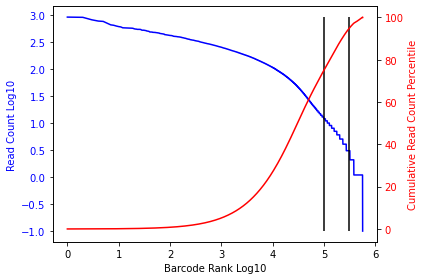

The read count cut off at the 75 th percentile is 12
The read count cut off at the 95 th percentile is 3
Finished processing sample BB_RT_1b_340_335_Hek1053
Processing sample BB_RT_1b_ODT_243_Hek1053
processed 1000 bcs, 8885 reads
processed 2000 bcs, 17351 reads
processed 3000 bcs, 26793 reads
processed 4000 bcs, 35630 reads
processed 5000 bcs, 44816 reads
processed 6000 bcs, 53051 reads
processed 7000 bcs, 61150 reads
processed 8000 bcs, 69973 reads
processed 9000 bcs, 78025 reads
processed 10000 bcs, 86164 reads
processed 11000 bcs, 94543 reads
processed 12000 bcs, 103627 reads
processed 13000 bcs, 113100 reads
processed 14000 bcs, 122233 reads
processed 15000 bcs, 130887 reads
processed 16000 bcs, 139643 reads
processed 17000 bcs, 148492 reads
processed 18000 bcs, 157718 reads
processed 19000 bcs, 166482 reads
processed 20000 bcs, 176085 reads
processed 21000 bcs, 185822 reads
processed 22000 bcs, 195703 reads
processed 23000 bcs, 203486 reads
processed 24000 bcs, 211617 reads
proce

processed 231000 bcs, 1984267 reads
processed 232000 bcs, 1992336 reads
processed 233000 bcs, 2000287 reads
processed 234000 bcs, 2008311 reads
processed 235000 bcs, 2018368 reads
processed 236000 bcs, 2026926 reads
processed 237000 bcs, 2035867 reads
processed 238000 bcs, 2043800 reads
processed 239000 bcs, 2051705 reads
processed 240000 bcs, 2059395 reads
processed 241000 bcs, 2066759 reads
processed 242000 bcs, 2073991 reads
processed 243000 bcs, 2082313 reads
processed 244000 bcs, 2089875 reads
processed 245000 bcs, 2096353 reads
processed 246000 bcs, 2103101 reads
processed 247000 bcs, 2109752 reads
processed 248000 bcs, 2117648 reads
processed 249000 bcs, 2126507 reads
processed 250000 bcs, 2134641 reads
processed 251000 bcs, 2142266 reads
processed 252000 bcs, 2149780 reads
processed 253000 bcs, 2157448 reads
processed 254000 bcs, 2165890 reads
processed 255000 bcs, 2174686 reads
processed 256000 bcs, 2182501 reads
processed 257000 bcs, 2189528 reads
processed 258000 bcs, 219684

processed 459000 bcs, 4064868 reads
processed 460000 bcs, 4073318 reads
processed 461000 bcs, 4080754 reads
processed 462000 bcs, 4088354 reads
processed 463000 bcs, 4097331 reads
processed 464000 bcs, 4105703 reads
processed 465000 bcs, 4115066 reads
processed 466000 bcs, 4124680 reads
processed 467000 bcs, 4133161 reads
processed 468000 bcs, 4142124 reads
processed 469000 bcs, 4150840 reads
processed 470000 bcs, 4158679 reads
processed 471000 bcs, 4167373 reads
processed 472000 bcs, 4175652 reads
processed 473000 bcs, 4185218 reads
processed 474000 bcs, 4193627 reads
processed 475000 bcs, 4201017 reads
processed 476000 bcs, 4209741 reads
processed 477000 bcs, 4217520 reads
processed 478000 bcs, 4227085 reads
processed 479000 bcs, 4236960 reads
processed 480000 bcs, 4247105 reads
processed 481000 bcs, 4256170 reads
processed 482000 bcs, 4264902 reads
processed 483000 bcs, 4274414 reads
processed 484000 bcs, 4283446 reads
processed 485000 bcs, 4292497 reads
processed 486000 bcs, 430265

processed 687000 bcs, 5980501 reads
processed 688000 bcs, 5987631 reads
processed 689000 bcs, 5994132 reads
processed 690000 bcs, 6003295 reads
processed 691000 bcs, 6011658 reads
processed 692000 bcs, 6019805 reads
processed 693000 bcs, 6028779 reads
processed 694000 bcs, 6037864 reads
processed 695000 bcs, 6046870 reads
processed 696000 bcs, 6056862 reads
processed 697000 bcs, 6066987 reads
processed 698000 bcs, 6075901 reads
processed 699000 bcs, 6084529 reads
processed 700000 bcs, 6092429 reads
processed 701000 bcs, 6100759 reads
processed 702000 bcs, 6108715 reads
processed 703000 bcs, 6117278 reads
processed 704000 bcs, 6124906 reads
processed 705000 bcs, 6133753 reads
processed 706000 bcs, 6142855 reads
processed 707000 bcs, 6151595 reads
processed 708000 bcs, 6159441 reads
processed 709000 bcs, 6168056 reads
processed 710000 bcs, 6176774 reads
processed 711000 bcs, 6186065 reads
processed 712000 bcs, 6194951 reads
processed 713000 bcs, 6204039 reads
processed 714000 bcs, 621347

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


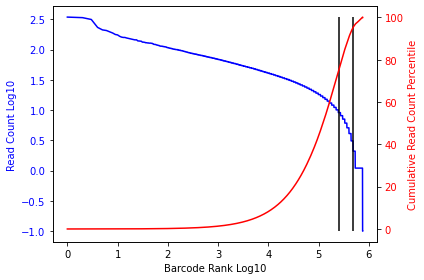

The read count cut off at the 75 th percentile is 9
The read count cut off at the 95 th percentile is 3
Finished processing sample BB_RT_1b_ODT_243_Hek1053
Processing sample BB_RT_1b_ODT_335_Hek1053
processed 1000 bcs, 6056 reads
processed 2000 bcs, 13476 reads
processed 3000 bcs, 20019 reads
processed 4000 bcs, 26869 reads
processed 5000 bcs, 33542 reads
processed 6000 bcs, 40395 reads
processed 7000 bcs, 47064 reads
processed 8000 bcs, 55212 reads
processed 9000 bcs, 63284 reads
processed 10000 bcs, 70672 reads
processed 11000 bcs, 78052 reads
processed 12000 bcs, 84542 reads
processed 13000 bcs, 91573 reads
processed 14000 bcs, 97947 reads
processed 15000 bcs, 104185 reads
processed 16000 bcs, 111097 reads
processed 17000 bcs, 118220 reads
processed 18000 bcs, 124541 reads
processed 19000 bcs, 129789 reads
processed 20000 bcs, 136193 reads
processed 21000 bcs, 143947 reads
processed 22000 bcs, 150772 reads
processed 23000 bcs, 157218 reads
processed 24000 bcs, 164334 reads
processed

processed 232000 bcs, 1690837 reads
processed 233000 bcs, 1699723 reads
processed 234000 bcs, 1708973 reads
processed 235000 bcs, 1716702 reads
processed 236000 bcs, 1724371 reads
processed 237000 bcs, 1732789 reads
processed 238000 bcs, 1740714 reads
processed 239000 bcs, 1749351 reads
processed 240000 bcs, 1757466 reads
processed 241000 bcs, 1766895 reads
processed 242000 bcs, 1776016 reads
processed 243000 bcs, 1785570 reads
processed 244000 bcs, 1794492 reads
processed 245000 bcs, 1802432 reads
processed 246000 bcs, 1811053 reads
processed 247000 bcs, 1819551 reads
processed 248000 bcs, 1827476 reads
processed 249000 bcs, 1835989 reads
processed 250000 bcs, 1844403 reads
processed 251000 bcs, 1852266 reads
processed 252000 bcs, 1858561 reads
processed 253000 bcs, 1864635 reads
processed 254000 bcs, 1871092 reads
processed 255000 bcs, 1878034 reads
processed 256000 bcs, 1885795 reads
processed 257000 bcs, 1891337 reads
processed 258000 bcs, 1897600 reads
processed 259000 bcs, 190378

processed 462000 bcs, 3336932 reads
processed 463000 bcs, 3343831 reads
processed 464000 bcs, 3349119 reads
processed 465000 bcs, 3355100 reads
processed 466000 bcs, 3360761 reads
processed 467000 bcs, 3366914 reads
processed 468000 bcs, 3373881 reads
processed 469000 bcs, 3380058 reads
processed 470000 bcs, 3386102 reads
processed 471000 bcs, 3392692 reads
processed 472000 bcs, 3399342 reads
processed 473000 bcs, 3405686 reads
processed 474000 bcs, 3412672 reads
processed 475000 bcs, 3417784 reads
processed 476000 bcs, 3423592 reads
processed 477000 bcs, 3429691 reads
processed 478000 bcs, 3435137 reads
0 columns will be removed during this process.
Columns:  []


/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


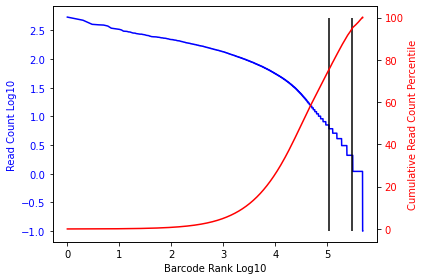

The read count cut off at the 75 th percentile is 7
The read count cut off at the 95 th percentile is 2
Finished processing sample BB_RT_1b_ODT_335_Hek1053
Processing sample BB_RT_1_ODT_243_Cos1053
processed 1000 bcs, 24604 reads
processed 2000 bcs, 51614 reads
processed 3000 bcs, 75256 reads
processed 4000 bcs, 99249 reads
processed 5000 bcs, 123286 reads
processed 6000 bcs, 147672 reads
processed 7000 bcs, 173548 reads
processed 8000 bcs, 198642 reads
processed 9000 bcs, 223608 reads
processed 10000 bcs, 246400 reads
processed 11000 bcs, 272685 reads
processed 12000 bcs, 297961 reads
processed 13000 bcs, 320749 reads
processed 14000 bcs, 344085 reads
processed 15000 bcs, 368117 reads
processed 16000 bcs, 393169 reads
processed 17000 bcs, 423770 reads
processed 18000 bcs, 451746 reads
processed 19000 bcs, 476725 reads
processed 20000 bcs, 504083 reads
processed 21000 bcs, 528039 reads
processed 22000 bcs, 553102 reads
processed 23000 bcs, 579669 reads
processed 24000 bcs, 605167 reads

processed 228000 bcs, 5686353 reads
processed 229000 bcs, 5708091 reads
processed 230000 bcs, 5730680 reads
processed 231000 bcs, 5754378 reads
processed 232000 bcs, 5776467 reads
processed 233000 bcs, 5799824 reads
processed 234000 bcs, 5823419 reads
processed 235000 bcs, 5845540 reads
processed 236000 bcs, 5867392 reads
processed 237000 bcs, 5891212 reads
processed 238000 bcs, 5915234 reads
processed 239000 bcs, 5940400 reads
processed 240000 bcs, 5964455 reads
processed 241000 bcs, 5987610 reads
processed 242000 bcs, 6009665 reads
processed 243000 bcs, 6034686 reads
processed 244000 bcs, 6066338 reads
processed 245000 bcs, 6091558 reads
processed 246000 bcs, 6113193 reads
processed 247000 bcs, 6136497 reads
processed 248000 bcs, 6160051 reads
processed 249000 bcs, 6184261 reads
processed 250000 bcs, 6206934 reads
processed 251000 bcs, 6228040 reads
processed 252000 bcs, 6250856 reads
processed 253000 bcs, 6273904 reads
processed 254000 bcs, 6294891 reads
processed 255000 bcs, 631825

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


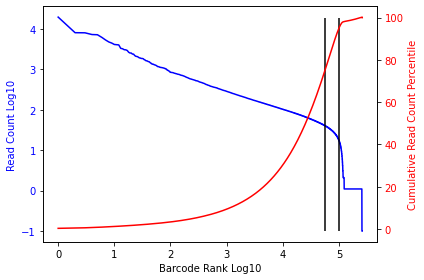

The read count cut off at the 75 th percentile is 40
The read count cut off at the 95 th percentile is 17
Finished processing sample BB_RT_1_ODT_243_Cos1053
Processing sample BB_RT_1_ODT_243_Hek1053
processed 1000 bcs, 10899 reads
processed 2000 bcs, 20933 reads
processed 3000 bcs, 33093 reads
processed 4000 bcs, 44797 reads
processed 5000 bcs, 56682 reads
processed 6000 bcs, 67620 reads
processed 7000 bcs, 77846 reads
processed 8000 bcs, 89100 reads
processed 9000 bcs, 99868 reads
processed 10000 bcs, 110402 reads
processed 11000 bcs, 121372 reads
processed 12000 bcs, 133199 reads
processed 13000 bcs, 145868 reads
processed 14000 bcs, 157366 reads
processed 15000 bcs, 168826 reads
processed 16000 bcs, 179972 reads
processed 17000 bcs, 191951 reads
processed 18000 bcs, 204275 reads
processed 19000 bcs, 215405 reads
processed 20000 bcs, 227058 reads
processed 21000 bcs, 239140 reads
processed 22000 bcs, 251289 reads
processed 23000 bcs, 263058 reads
processed 24000 bcs, 272711 reads
pro

processed 230000 bcs, 2538124 reads
processed 231000 bcs, 2550708 reads
processed 232000 bcs, 2563347 reads
processed 233000 bcs, 2575738 reads
processed 234000 bcs, 2586124 reads
processed 235000 bcs, 2595762 reads
processed 236000 bcs, 2605530 reads
processed 237000 bcs, 2615864 reads
processed 238000 bcs, 2625719 reads
processed 239000 bcs, 2635607 reads
processed 240000 bcs, 2648077 reads
processed 241000 bcs, 2659204 reads
processed 242000 bcs, 2670637 reads
processed 243000 bcs, 2680446 reads
processed 244000 bcs, 2690354 reads
processed 245000 bcs, 2700854 reads
processed 246000 bcs, 2709803 reads
processed 247000 bcs, 2719236 reads
processed 248000 bcs, 2729196 reads
processed 249000 bcs, 2739566 reads
processed 250000 bcs, 2748247 reads
processed 251000 bcs, 2756780 reads
processed 252000 bcs, 2765539 reads
processed 253000 bcs, 2774515 reads
processed 254000 bcs, 2785146 reads
processed 255000 bcs, 2796042 reads
processed 256000 bcs, 2805352 reads
processed 257000 bcs, 281495

processed 458000 bcs, 5189573 reads
processed 459000 bcs, 5202178 reads
processed 460000 bcs, 5212630 reads
processed 461000 bcs, 5224544 reads
processed 462000 bcs, 5236105 reads
processed 463000 bcs, 5248484 reads
processed 464000 bcs, 5261389 reads
processed 465000 bcs, 5274310 reads
processed 466000 bcs, 5287455 reads
processed 467000 bcs, 5299811 reads
processed 468000 bcs, 5311333 reads
processed 469000 bcs, 5324129 reads
processed 470000 bcs, 5334636 reads
processed 471000 bcs, 5344155 reads
processed 472000 bcs, 5353884 reads
processed 473000 bcs, 5365260 reads
processed 474000 bcs, 5376019 reads
processed 475000 bcs, 5388028 reads
processed 476000 bcs, 5400309 reads
processed 477000 bcs, 5411081 reads
processed 478000 bcs, 5422579 reads
processed 479000 bcs, 5434008 reads
processed 480000 bcs, 5444680 reads
processed 481000 bcs, 5455483 reads
processed 482000 bcs, 5465767 reads
processed 483000 bcs, 5477754 reads
processed 484000 bcs, 5488571 reads
processed 485000 bcs, 549809

processed 687000 bcs, 7685090 reads
processed 688000 bcs, 7695996 reads
processed 689000 bcs, 7705795 reads
processed 690000 bcs, 7716489 reads
processed 691000 bcs, 7726635 reads
processed 692000 bcs, 7736728 reads
processed 693000 bcs, 7746727 reads
processed 694000 bcs, 7755246 reads
processed 695000 bcs, 7764400 reads
processed 696000 bcs, 7773423 reads
processed 697000 bcs, 7782555 reads
processed 698000 bcs, 7790793 reads
processed 699000 bcs, 7801762 reads
processed 700000 bcs, 7811823 reads
processed 701000 bcs, 7820840 reads
processed 702000 bcs, 7829483 reads
processed 703000 bcs, 7839073 reads
processed 704000 bcs, 7847017 reads
processed 705000 bcs, 7859219 reads
processed 706000 bcs, 7870308 reads
processed 707000 bcs, 7880948 reads
processed 708000 bcs, 7892044 reads
processed 709000 bcs, 7903627 reads
processed 710000 bcs, 7914284 reads
processed 711000 bcs, 7926250 reads
processed 712000 bcs, 7939919 reads
processed 713000 bcs, 7951098 reads
processed 714000 bcs, 796297

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


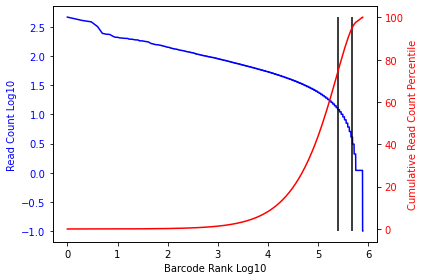

The read count cut off at the 75 th percentile is 12
The read count cut off at the 95 th percentile is 4
Finished processing sample BB_RT_1_ODT_243_Hek1053
Processing sample BB_RT_1_ODT_335_Cos1053
processed 1000 bcs, 25118 reads
processed 2000 bcs, 50493 reads
processed 3000 bcs, 72689 reads
processed 4000 bcs, 96130 reads
processed 5000 bcs, 119179 reads
processed 6000 bcs, 142863 reads
processed 7000 bcs, 166343 reads
processed 8000 bcs, 203761 reads
processed 9000 bcs, 228364 reads
processed 10000 bcs, 252280 reads
processed 11000 bcs, 274051 reads
processed 12000 bcs, 296656 reads
processed 13000 bcs, 318123 reads
processed 14000 bcs, 342448 reads
processed 15000 bcs, 364476 reads
processed 16000 bcs, 386584 reads
processed 17000 bcs, 410518 reads
processed 18000 bcs, 431928 reads
processed 19000 bcs, 452685 reads
processed 20000 bcs, 479933 reads
processed 21000 bcs, 505201 reads
processed 22000 bcs, 527815 reads
processed 23000 bcs, 550167 reads
processed 24000 bcs, 577345 reads

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


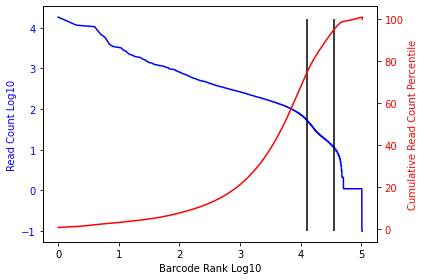

The read count cut off at the 75 th percentile is 51
The read count cut off at the 95 th percentile is 11
Finished processing sample BB_RT_1_ODT_335_Cos1053
Processing sample BB_RT_1_ODT_335_Hek1053
processed 1000 bcs, 14435 reads
processed 2000 bcs, 28121 reads
processed 3000 bcs, 44435 reads
processed 4000 bcs, 59803 reads
processed 5000 bcs, 75611 reads
processed 6000 bcs, 89742 reads
processed 7000 bcs, 104161 reads
processed 8000 bcs, 118558 reads
processed 9000 bcs, 132672 reads
processed 10000 bcs, 148267 reads
processed 11000 bcs, 166405 reads
processed 12000 bcs, 182861 reads
processed 13000 bcs, 199825 reads
processed 14000 bcs, 215009 reads
processed 15000 bcs, 230869 reads
processed 16000 bcs, 246614 reads
processed 17000 bcs, 260723 reads
processed 18000 bcs, 277356 reads
processed 19000 bcs, 291319 reads
processed 20000 bcs, 306692 reads
processed 21000 bcs, 319370 reads
processed 22000 bcs, 334917 reads
processed 23000 bcs, 349684 reads
processed 24000 bcs, 364391 reads


processed 228000 bcs, 3332370 reads
processed 229000 bcs, 3345241 reads
processed 230000 bcs, 3356326 reads
processed 231000 bcs, 3368948 reads
processed 232000 bcs, 3379233 reads
processed 233000 bcs, 3390003 reads
processed 234000 bcs, 3404223 reads
processed 235000 bcs, 3415701 reads
processed 236000 bcs, 3426824 reads
processed 237000 bcs, 3437564 reads
processed 238000 bcs, 3448304 reads
processed 239000 bcs, 3463327 reads
processed 240000 bcs, 3480249 reads
processed 241000 bcs, 3499423 reads
processed 242000 bcs, 3518004 reads
processed 243000 bcs, 3538487 reads
processed 244000 bcs, 3559806 reads
processed 245000 bcs, 3575412 reads
processed 246000 bcs, 3593655 reads
processed 247000 bcs, 3611237 reads
processed 248000 bcs, 3631343 reads
processed 249000 bcs, 3651165 reads
processed 250000 bcs, 3667841 reads
processed 251000 bcs, 3685439 reads
processed 252000 bcs, 3705064 reads
processed 253000 bcs, 3725868 reads
processed 254000 bcs, 3745837 reads
processed 255000 bcs, 376329

processed 456000 bcs, 7150060 reads
processed 457000 bcs, 7162066 reads
processed 458000 bcs, 7175233 reads
processed 459000 bcs, 7187978 reads
processed 460000 bcs, 7199770 reads
processed 461000 bcs, 7213073 reads
processed 462000 bcs, 7225513 reads
processed 463000 bcs, 7240654 reads
processed 464000 bcs, 7255251 reads
processed 465000 bcs, 7270897 reads
processed 466000 bcs, 7285820 reads
processed 467000 bcs, 7298971 reads
processed 468000 bcs, 7308960 reads
processed 469000 bcs, 7322270 reads
processed 470000 bcs, 7334373 reads
processed 471000 bcs, 7346750 reads
processed 472000 bcs, 7359617 reads
processed 473000 bcs, 7371658 reads
processed 474000 bcs, 7388932 reads
processed 475000 bcs, 7404061 reads
processed 476000 bcs, 7420820 reads
processed 477000 bcs, 7434036 reads
processed 478000 bcs, 7446722 reads
processed 479000 bcs, 7462216 reads
processed 480000 bcs, 7477797 reads
processed 481000 bcs, 7491277 reads
processed 482000 bcs, 7503158 reads
processed 483000 bcs, 751730

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


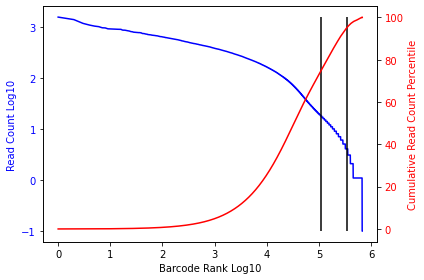

The read count cut off at the 75 th percentile is 18
The read count cut off at the 95 th percentile is 4
Finished processing sample BB_RT_1_ODT_335_Hek1053
Processing sample BB_RT_2_340_243_Cos1054
processed 1000 bcs, 32012 reads
processed 2000 bcs, 64638 reads
processed 3000 bcs, 94091 reads
processed 4000 bcs, 131267 reads
processed 5000 bcs, 160690 reads
processed 6000 bcs, 193012 reads
processed 7000 bcs, 221830 reads
processed 8000 bcs, 252751 reads
processed 9000 bcs, 285582 reads
processed 10000 bcs, 316278 reads
processed 11000 bcs, 346674 reads
processed 12000 bcs, 394465 reads
processed 13000 bcs, 423246 reads
processed 14000 bcs, 453127 reads
processed 15000 bcs, 483431 reads
processed 16000 bcs, 510690 reads
processed 17000 bcs, 538733 reads
processed 18000 bcs, 569247 reads
processed 19000 bcs, 597890 reads
processed 20000 bcs, 627347 reads
processed 21000 bcs, 655779 reads
processed 22000 bcs, 685721 reads
processed 23000 bcs, 716682 reads
processed 24000 bcs, 745751 read

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


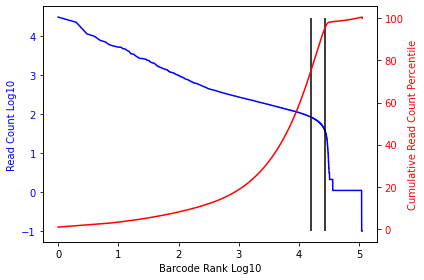

The read count cut off at the 75 th percentile is 83
The read count cut off at the 95 th percentile is 39
Finished processing sample BB_RT_2_340_243_Cos1054
Processing sample BB_RT_2_340_243_Hek1054
processed 1000 bcs, 10777 reads
processed 2000 bcs, 22589 reads
processed 3000 bcs, 34774 reads
processed 4000 bcs, 46595 reads
processed 5000 bcs, 57429 reads
processed 6000 bcs, 69526 reads
processed 7000 bcs, 80375 reads
processed 8000 bcs, 91610 reads
processed 9000 bcs, 104666 reads
processed 10000 bcs, 117256 reads
processed 11000 bcs, 128572 reads
processed 12000 bcs, 140480 reads
processed 13000 bcs, 152884 reads
processed 14000 bcs, 165927 reads
processed 15000 bcs, 178379 reads
processed 16000 bcs, 191146 reads
processed 17000 bcs, 201263 reads
processed 18000 bcs, 212982 reads
processed 19000 bcs, 224982 reads
processed 20000 bcs, 236531 reads
processed 21000 bcs, 248106 reads
processed 22000 bcs, 258822 reads
processed 23000 bcs, 270906 reads
processed 24000 bcs, 282410 reads
pr

processed 229000 bcs, 2646710 reads
processed 230000 bcs, 2660699 reads
processed 231000 bcs, 2674973 reads
processed 232000 bcs, 2687352 reads
processed 233000 bcs, 2700390 reads
processed 234000 bcs, 2712658 reads
processed 235000 bcs, 2726226 reads
processed 236000 bcs, 2739727 reads
processed 237000 bcs, 2752291 reads
processed 238000 bcs, 2765379 reads
processed 239000 bcs, 2779110 reads
processed 240000 bcs, 2793656 reads
processed 241000 bcs, 2808612 reads
processed 242000 bcs, 2821902 reads
processed 243000 bcs, 2835217 reads
processed 244000 bcs, 2849161 reads
processed 245000 bcs, 2862216 reads
processed 246000 bcs, 2875265 reads
processed 247000 bcs, 2887972 reads
processed 248000 bcs, 2901314 reads
processed 249000 bcs, 2915358 reads
processed 250000 bcs, 2928822 reads
processed 251000 bcs, 2942156 reads
processed 252000 bcs, 2956169 reads
processed 253000 bcs, 2968313 reads
processed 254000 bcs, 2981937 reads
processed 255000 bcs, 2995166 reads
processed 256000 bcs, 300894

processed 458000 bcs, 5325676 reads
processed 459000 bcs, 5335181 reads
processed 460000 bcs, 5344786 reads
processed 461000 bcs, 5355744 reads
processed 462000 bcs, 5365687 reads
processed 463000 bcs, 5377423 reads
processed 464000 bcs, 5389905 reads
processed 465000 bcs, 5401018 reads
processed 466000 bcs, 5411668 reads
processed 467000 bcs, 5422043 reads
processed 468000 bcs, 5432923 reads
processed 469000 bcs, 5443542 reads
processed 470000 bcs, 5455656 reads
processed 471000 bcs, 5467246 reads
processed 472000 bcs, 5477736 reads
processed 473000 bcs, 5489473 reads
processed 474000 bcs, 5499479 reads
processed 475000 bcs, 5508907 reads
processed 476000 bcs, 5519569 reads
processed 477000 bcs, 5530066 reads
processed 478000 bcs, 5540442 reads
processed 479000 bcs, 5551990 reads
processed 480000 bcs, 5563771 reads
processed 481000 bcs, 5574557 reads
processed 482000 bcs, 5584570 reads
processed 483000 bcs, 5595622 reads
processed 484000 bcs, 5604453 reads
processed 485000 bcs, 561416

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


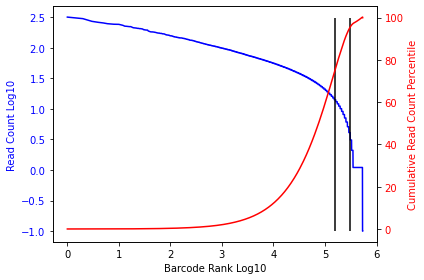

The read count cut off at the 75 th percentile is 14
The read count cut off at the 95 th percentile is 4
Finished processing sample BB_RT_2_340_243_Hek1054
Processing sample BB_RT_2_340_335_Cos1054
processed 1000 bcs, 32447 reads
processed 2000 bcs, 71992 reads
processed 3000 bcs, 102330 reads
processed 4000 bcs, 139807 reads
processed 5000 bcs, 174517 reads
processed 6000 bcs, 207548 reads
processed 7000 bcs, 234947 reads
processed 8000 bcs, 265491 reads
processed 9000 bcs, 297389 reads
processed 10000 bcs, 329792 reads
processed 11000 bcs, 362178 reads
processed 12000 bcs, 395691 reads
processed 13000 bcs, 426885 reads
processed 14000 bcs, 461398 reads
processed 15000 bcs, 489384 reads
processed 16000 bcs, 518114 reads
processed 17000 bcs, 551425 reads
processed 18000 bcs, 584305 reads
processed 19000 bcs, 620147 reads
processed 20000 bcs, 655980 reads
processed 21000 bcs, 690333 reads
processed 22000 bcs, 728125 reads
processed 23000 bcs, 763356 reads
processed 24000 bcs, 802715 rea

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


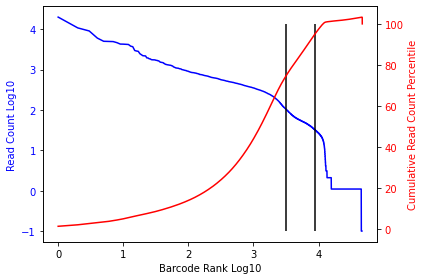

The read count cut off at the 75 th percentile is 102
The read count cut off at the 95 th percentile is 32
Finished processing sample BB_RT_2_340_335_Cos1054
Processing sample BB_RT_2_340_335_Hek1054
processed 1000 bcs, 12863 reads
processed 2000 bcs, 29202 reads
processed 3000 bcs, 43637 reads
processed 4000 bcs, 58544 reads
processed 5000 bcs, 72446 reads
processed 6000 bcs, 90041 reads
processed 7000 bcs, 107386 reads
processed 8000 bcs, 125896 reads
processed 9000 bcs, 142712 reads
processed 10000 bcs, 158731 reads
processed 11000 bcs, 173575 reads
processed 12000 bcs, 190798 reads
processed 13000 bcs, 208215 reads
processed 14000 bcs, 224484 reads
processed 15000 bcs, 238561 reads
processed 16000 bcs, 254138 reads
processed 17000 bcs, 269404 reads
processed 18000 bcs, 285312 reads
processed 19000 bcs, 301662 reads
processed 20000 bcs, 316645 reads
processed 21000 bcs, 332066 reads
processed 22000 bcs, 346682 reads
processed 23000 bcs, 363267 reads
processed 24000 bcs, 379379 reads

processed 228000 bcs, 3693511 reads
processed 229000 bcs, 3710539 reads
processed 230000 bcs, 3727357 reads
processed 231000 bcs, 3745005 reads
processed 232000 bcs, 3763240 reads
processed 233000 bcs, 3779451 reads
processed 234000 bcs, 3798021 reads
processed 235000 bcs, 3811609 reads
processed 236000 bcs, 3829060 reads
processed 237000 bcs, 3849988 reads
processed 238000 bcs, 3863056 reads
processed 239000 bcs, 3878599 reads
processed 240000 bcs, 3894656 reads
processed 241000 bcs, 3912076 reads
processed 242000 bcs, 3925111 reads
processed 243000 bcs, 3941526 reads
processed 244000 bcs, 3960490 reads
processed 245000 bcs, 3975386 reads
processed 246000 bcs, 3992191 reads
processed 247000 bcs, 4012485 reads
processed 248000 bcs, 4030299 reads
processed 249000 bcs, 4047153 reads
processed 250000 bcs, 4064642 reads
processed 251000 bcs, 4081086 reads
processed 252000 bcs, 4099489 reads
processed 253000 bcs, 4116296 reads
processed 254000 bcs, 4131180 reads
processed 255000 bcs, 414690

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


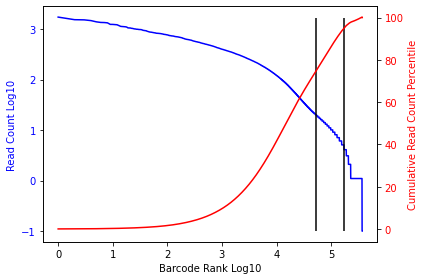

The read count cut off at the 75 th percentile is 20
The read count cut off at the 95 th percentile is 4
Finished processing sample BB_RT_2_340_335_Hek1054
Processing sample BB_RT_2_ODT_243_Cos1054
processed 1000 bcs, 30618 reads
processed 2000 bcs, 64482 reads
processed 3000 bcs, 93917 reads
processed 4000 bcs, 124973 reads
processed 5000 bcs, 159570 reads
processed 6000 bcs, 189532 reads
processed 7000 bcs, 221030 reads
processed 8000 bcs, 249299 reads
processed 9000 bcs, 280084 reads
processed 10000 bcs, 311659 reads
processed 11000 bcs, 344996 reads
processed 12000 bcs, 372834 reads
processed 13000 bcs, 402715 reads
processed 14000 bcs, 451250 reads
processed 15000 bcs, 478747 reads
processed 16000 bcs, 508749 reads
processed 17000 bcs, 539790 reads
processed 18000 bcs, 572658 reads
processed 19000 bcs, 601190 reads
processed 20000 bcs, 627516 reads
processed 21000 bcs, 655690 reads
processed 22000 bcs, 685864 reads
processed 23000 bcs, 714691 reads
processed 24000 bcs, 742865 read

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


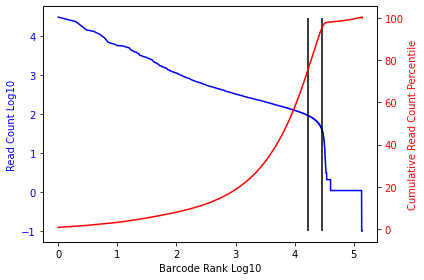

The read count cut off at the 75 th percentile is 93
The read count cut off at the 95 th percentile is 42
Finished processing sample BB_RT_2_ODT_243_Cos1054
Processing sample BB_RT_2_ODT_243_Hek1054
processed 1000 bcs, 12074 reads
processed 2000 bcs, 25430 reads
processed 3000 bcs, 39291 reads
processed 4000 bcs, 52145 reads
processed 5000 bcs, 64535 reads
processed 6000 bcs, 77110 reads
processed 7000 bcs, 90005 reads
processed 8000 bcs, 102994 reads
processed 9000 bcs, 117724 reads
processed 10000 bcs, 131290 reads
processed 11000 bcs, 143703 reads
processed 12000 bcs, 158063 reads
processed 13000 bcs, 172239 reads
processed 14000 bcs, 186172 reads
processed 15000 bcs, 201006 reads
processed 16000 bcs, 214545 reads
processed 17000 bcs, 226491 reads
processed 18000 bcs, 240096 reads
processed 19000 bcs, 253484 reads
processed 20000 bcs, 265818 reads
processed 21000 bcs, 278781 reads
processed 22000 bcs, 291512 reads
processed 23000 bcs, 305329 reads
processed 24000 bcs, 318295 reads
p

processed 229000 bcs, 3031905 reads
processed 230000 bcs, 3048068 reads
processed 231000 bcs, 3064370 reads
processed 232000 bcs, 3080672 reads
processed 233000 bcs, 3096083 reads
processed 234000 bcs, 3111002 reads
processed 235000 bcs, 3126510 reads
processed 236000 bcs, 3141459 reads
processed 237000 bcs, 3155079 reads
processed 238000 bcs, 3170234 reads
processed 239000 bcs, 3186769 reads
processed 240000 bcs, 3202600 reads
processed 241000 bcs, 3217358 reads
processed 242000 bcs, 3233127 reads
processed 243000 bcs, 3247530 reads
processed 244000 bcs, 3262659 reads
processed 245000 bcs, 3278259 reads
processed 246000 bcs, 3293569 reads
processed 247000 bcs, 3308134 reads
processed 248000 bcs, 3323146 reads
processed 249000 bcs, 3338175 reads
processed 250000 bcs, 3351109 reads
processed 251000 bcs, 3365274 reads
processed 252000 bcs, 3379669 reads
processed 253000 bcs, 3394563 reads
processed 254000 bcs, 3409560 reads
processed 255000 bcs, 3424772 reads
processed 256000 bcs, 344109

processed 457000 bcs, 6067793 reads
processed 458000 bcs, 6079331 reads
processed 459000 bcs, 6090654 reads
processed 460000 bcs, 6103438 reads
processed 461000 bcs, 6114095 reads
processed 462000 bcs, 6125538 reads
processed 463000 bcs, 6140025 reads
processed 464000 bcs, 6152482 reads
processed 465000 bcs, 6164490 reads
processed 466000 bcs, 6177097 reads
processed 467000 bcs, 6188297 reads
processed 468000 bcs, 6198980 reads
processed 469000 bcs, 6209568 reads
processed 470000 bcs, 6220653 reads
processed 471000 bcs, 6232765 reads
processed 472000 bcs, 6244565 reads
processed 473000 bcs, 6255722 reads
processed 474000 bcs, 6266826 reads
processed 475000 bcs, 6279190 reads
processed 476000 bcs, 6292018 reads
processed 477000 bcs, 6304483 reads
processed 478000 bcs, 6317706 reads
processed 479000 bcs, 6332289 reads
processed 480000 bcs, 6347285 reads
processed 481000 bcs, 6361958 reads
processed 482000 bcs, 6374899 reads
processed 483000 bcs, 6387422 reads
processed 484000 bcs, 639937

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


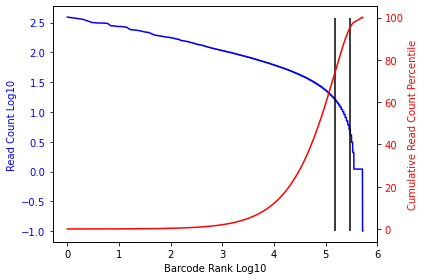

The read count cut off at the 75 th percentile is 16
The read count cut off at the 95 th percentile is 5
Finished processing sample BB_RT_2_ODT_243_Hek1054
Processing sample BB_RT_2_ODT_335_Cos1054
processed 1000 bcs, 36154 reads
processed 2000 bcs, 67517 reads
processed 3000 bcs, 105897 reads
processed 4000 bcs, 135387 reads
processed 5000 bcs, 169629 reads
processed 6000 bcs, 198429 reads
processed 7000 bcs, 230757 reads
processed 8000 bcs, 260903 reads
processed 9000 bcs, 290831 reads
processed 10000 bcs, 320740 reads
processed 11000 bcs, 347198 reads
processed 12000 bcs, 380467 reads
processed 13000 bcs, 412834 reads
processed 14000 bcs, 445987 reads
processed 15000 bcs, 482180 reads
processed 16000 bcs, 520913 reads
processed 17000 bcs, 557761 reads
processed 18000 bcs, 597872 reads
processed 19000 bcs, 627621 reads
processed 20000 bcs, 662517 reads
processed 21000 bcs, 696132 reads
processed 22000 bcs, 725064 reads
processed 23000 bcs, 758406 reads
processed 24000 bcs, 786161 rea

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


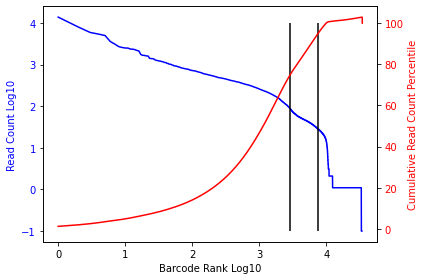

The read count cut off at the 75 th percentile is 87
The read count cut off at the 95 th percentile is 28
Finished processing sample BB_RT_2_ODT_335_Cos1054
Processing sample BB_RT_2_ODT_335_Hek1054
processed 1000 bcs, 11387 reads
processed 2000 bcs, 23351 reads
processed 3000 bcs, 34942 reads
processed 4000 bcs, 48092 reads
processed 5000 bcs, 61199 reads
processed 6000 bcs, 75479 reads
processed 7000 bcs, 88470 reads
processed 8000 bcs, 102159 reads
processed 9000 bcs, 114564 reads
processed 10000 bcs, 126787 reads
processed 11000 bcs, 141609 reads
processed 12000 bcs, 154522 reads
processed 13000 bcs, 166282 reads
processed 14000 bcs, 179655 reads
processed 15000 bcs, 193083 reads
processed 16000 bcs, 205930 reads
processed 17000 bcs, 218152 reads
processed 18000 bcs, 231531 reads
processed 19000 bcs, 245589 reads
processed 20000 bcs, 259388 reads
processed 21000 bcs, 275259 reads
processed 22000 bcs, 289840 reads
processed 23000 bcs, 304390 reads
processed 24000 bcs, 318936 reads
p

processed 229000 bcs, 3057969 reads
processed 230000 bcs, 3067737 reads
processed 231000 bcs, 3077804 reads
processed 232000 bcs, 3088164 reads
processed 233000 bcs, 3097487 reads
processed 234000 bcs, 3110562 reads
processed 235000 bcs, 3122086 reads
processed 236000 bcs, 3134599 reads
processed 237000 bcs, 3144715 reads
processed 238000 bcs, 3156551 reads
processed 239000 bcs, 3167659 reads
processed 240000 bcs, 3179841 reads
processed 241000 bcs, 3192879 reads
processed 242000 bcs, 3206000 reads
processed 243000 bcs, 3217791 reads
processed 244000 bcs, 3232527 reads
processed 245000 bcs, 3246560 reads
processed 246000 bcs, 3261874 reads
processed 247000 bcs, 3277939 reads
processed 248000 bcs, 3292744 reads
processed 249000 bcs, 3307731 reads
processed 250000 bcs, 3322516 reads
processed 251000 bcs, 3334333 reads
processed 252000 bcs, 3348551 reads
processed 253000 bcs, 3362757 reads
processed 254000 bcs, 3373968 reads
processed 255000 bcs, 3386117 reads
processed 256000 bcs, 339770

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


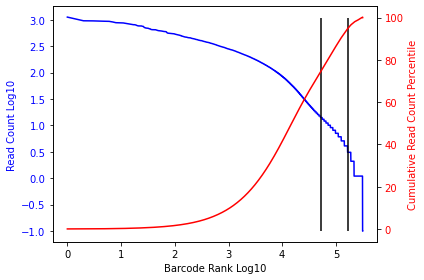

The read count cut off at the 75 th percentile is 14
The read count cut off at the 95 th percentile is 3
Finished processing sample BB_RT_2_ODT_335_Hek1054
Processing sample BB_RT_3_340_243_Cos1055
processed 1000 bcs, 3123 reads
processed 2000 bcs, 6130 reads
processed 3000 bcs, 9429 reads
processed 4000 bcs, 12686 reads
processed 5000 bcs, 15730 reads
processed 6000 bcs, 18848 reads
processed 7000 bcs, 21811 reads
processed 8000 bcs, 25058 reads
processed 9000 bcs, 27917 reads
processed 10000 bcs, 31121 reads
processed 11000 bcs, 34295 reads
processed 12000 bcs, 37708 reads
processed 13000 bcs, 40782 reads
processed 14000 bcs, 44129 reads
processed 15000 bcs, 47232 reads
processed 16000 bcs, 50428 reads
processed 17000 bcs, 53795 reads
processed 18000 bcs, 57052 reads
processed 19000 bcs, 60328 reads
processed 20000 bcs, 63808 reads
processed 21000 bcs, 67190 reads
processed 22000 bcs, 70313 reads
processed 23000 bcs, 73282 reads
processed 24000 bcs, 76512 reads
processed 25000 bcs, 8

processed 236000 bcs, 745379 reads
processed 237000 bcs, 748625 reads
processed 238000 bcs, 751650 reads
processed 239000 bcs, 754484 reads
processed 240000 bcs, 757460 reads
processed 241000 bcs, 760337 reads
processed 242000 bcs, 763083 reads
processed 243000 bcs, 765950 reads
processed 244000 bcs, 769483 reads
processed 245000 bcs, 772527 reads
processed 246000 bcs, 775428 reads
processed 247000 bcs, 778193 reads
processed 248000 bcs, 781177 reads
processed 249000 bcs, 784089 reads
processed 250000 bcs, 787438 reads
processed 251000 bcs, 790790 reads
processed 252000 bcs, 794233 reads
processed 253000 bcs, 797485 reads
processed 254000 bcs, 801362 reads
processed 255000 bcs, 804646 reads
processed 256000 bcs, 808176 reads
processed 257000 bcs, 811488 reads
processed 258000 bcs, 815048 reads
processed 259000 bcs, 818201 reads
processed 260000 bcs, 821634 reads
processed 261000 bcs, 824959 reads
processed 262000 bcs, 828505 reads
processed 263000 bcs, 831930 reads
processed 264000 bcs

processed 469000 bcs, 1517042 reads
processed 470000 bcs, 1520117 reads
processed 471000 bcs, 1523011 reads
processed 472000 bcs, 1525850 reads
processed 473000 bcs, 1528691 reads
processed 474000 bcs, 1531726 reads
processed 475000 bcs, 1534755 reads
processed 476000 bcs, 1537704 reads
processed 477000 bcs, 1540622 reads
processed 478000 bcs, 1543680 reads
processed 479000 bcs, 1546823 reads
processed 480000 bcs, 1550171 reads
processed 481000 bcs, 1553505 reads
processed 482000 bcs, 1556723 reads
processed 483000 bcs, 1559822 reads
processed 484000 bcs, 1562895 reads
processed 485000 bcs, 1565923 reads
processed 486000 bcs, 1568819 reads
processed 487000 bcs, 1571968 reads
processed 488000 bcs, 1574792 reads
processed 489000 bcs, 1577768 reads
processed 490000 bcs, 1580819 reads
processed 491000 bcs, 1584007 reads
processed 492000 bcs, 1587001 reads
processed 493000 bcs, 1589605 reads
processed 494000 bcs, 1592394 reads
processed 495000 bcs, 1595118 reads
processed 496000 bcs, 159808

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


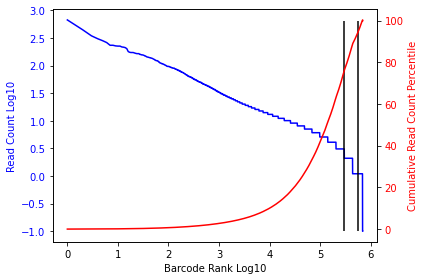

The read count cut off at the 75 th percentile is 3
The read count cut off at the 95 th percentile is 1
Finished processing sample BB_RT_3_340_243_Cos1055
Processing sample BB_RT_3_340_243_Hek1055
processed 1000 bcs, 4808 reads
processed 2000 bcs, 9984 reads
processed 3000 bcs, 14960 reads
processed 4000 bcs, 20457 reads
processed 5000 bcs, 25768 reads
processed 6000 bcs, 31413 reads
processed 7000 bcs, 36499 reads
processed 8000 bcs, 41606 reads
processed 9000 bcs, 46408 reads
processed 10000 bcs, 51411 reads
processed 11000 bcs, 56686 reads
processed 12000 bcs, 61377 reads
processed 13000 bcs, 66163 reads
processed 14000 bcs, 71298 reads
processed 15000 bcs, 76646 reads
processed 16000 bcs, 82183 reads
processed 17000 bcs, 88056 reads
processed 18000 bcs, 93418 reads
processed 19000 bcs, 98422 reads
processed 20000 bcs, 103365 reads
processed 21000 bcs, 108448 reads
processed 22000 bcs, 113746 reads
processed 23000 bcs, 119152 reads
processed 24000 bcs, 124234 reads
processed 25000 b

processed 235000 bcs, 1200240 reads
processed 236000 bcs, 1205307 reads
processed 237000 bcs, 1210175 reads
processed 238000 bcs, 1214629 reads
processed 239000 bcs, 1219322 reads
processed 240000 bcs, 1223738 reads
processed 241000 bcs, 1228610 reads
processed 242000 bcs, 1233756 reads
processed 243000 bcs, 1238943 reads
processed 244000 bcs, 1243866 reads
processed 245000 bcs, 1248396 reads
processed 246000 bcs, 1252870 reads
processed 247000 bcs, 1257506 reads
processed 248000 bcs, 1261924 reads
processed 249000 bcs, 1266595 reads
processed 250000 bcs, 1271741 reads
processed 251000 bcs, 1276772 reads
processed 252000 bcs, 1281430 reads
processed 253000 bcs, 1285762 reads
processed 254000 bcs, 1290600 reads
processed 255000 bcs, 1295507 reads
processed 256000 bcs, 1300077 reads
processed 257000 bcs, 1304616 reads
processed 258000 bcs, 1309105 reads
processed 259000 bcs, 1314184 reads
processed 260000 bcs, 1318560 reads
processed 261000 bcs, 1322436 reads
processed 262000 bcs, 132622

processed 465000 bcs, 2398154 reads
processed 466000 bcs, 2403707 reads
processed 467000 bcs, 2408787 reads
processed 468000 bcs, 2414249 reads
processed 469000 bcs, 2419454 reads
processed 470000 bcs, 2425027 reads
processed 471000 bcs, 2430507 reads
processed 472000 bcs, 2436700 reads
processed 473000 bcs, 2442344 reads
processed 474000 bcs, 2447944 reads
processed 475000 bcs, 2454006 reads
processed 476000 bcs, 2460140 reads
processed 477000 bcs, 2465932 reads
processed 478000 bcs, 2472112 reads
processed 479000 bcs, 2478044 reads
processed 480000 bcs, 2483553 reads
processed 481000 bcs, 2489377 reads
processed 482000 bcs, 2494724 reads
processed 483000 bcs, 2500219 reads
processed 484000 bcs, 2506056 reads
processed 485000 bcs, 2512057 reads
processed 486000 bcs, 2517664 reads
processed 487000 bcs, 2523551 reads
processed 488000 bcs, 2529454 reads
processed 489000 bcs, 2535059 reads
processed 490000 bcs, 2540461 reads
processed 491000 bcs, 2546290 reads
processed 492000 bcs, 255170

processed 694000 bcs, 3550367 reads
processed 695000 bcs, 3554491 reads
processed 696000 bcs, 3558671 reads
processed 697000 bcs, 3562472 reads
processed 698000 bcs, 3565808 reads
processed 699000 bcs, 3570195 reads
processed 700000 bcs, 3573875 reads
processed 701000 bcs, 3577351 reads
processed 702000 bcs, 3582374 reads
processed 703000 bcs, 3586797 reads
processed 704000 bcs, 3591677 reads
processed 705000 bcs, 3596699 reads
processed 706000 bcs, 3600727 reads
processed 707000 bcs, 3605049 reads
processed 708000 bcs, 3609275 reads
processed 709000 bcs, 3613371 reads
processed 710000 bcs, 3617494 reads
processed 711000 bcs, 3621484 reads
processed 712000 bcs, 3626205 reads
processed 713000 bcs, 3630887 reads
processed 714000 bcs, 3635260 reads
processed 715000 bcs, 3639195 reads
processed 716000 bcs, 3643715 reads
processed 717000 bcs, 3647755 reads
processed 718000 bcs, 3652463 reads
processed 719000 bcs, 3658183 reads
processed 720000 bcs, 3663671 reads
processed 721000 bcs, 366919

processed 923000 bcs, 4678173 reads
processed 924000 bcs, 4682721 reads
processed 925000 bcs, 4687726 reads
processed 926000 bcs, 4692640 reads
processed 927000 bcs, 4697188 reads
processed 928000 bcs, 4701640 reads
processed 929000 bcs, 4706169 reads
processed 930000 bcs, 4710610 reads
processed 931000 bcs, 4715316 reads
processed 932000 bcs, 4719861 reads
processed 933000 bcs, 4723883 reads
processed 934000 bcs, 4728018 reads
processed 935000 bcs, 4732722 reads
processed 936000 bcs, 4736873 reads
processed 937000 bcs, 4741634 reads
processed 938000 bcs, 4746174 reads
processed 939000 bcs, 4751248 reads
processed 940000 bcs, 4756474 reads
processed 941000 bcs, 4761505 reads
processed 942000 bcs, 4766434 reads
processed 943000 bcs, 4771389 reads
processed 944000 bcs, 4776344 reads
processed 945000 bcs, 4781212 reads
processed 946000 bcs, 4786377 reads
processed 947000 bcs, 4791888 reads
processed 948000 bcs, 4797259 reads
processed 949000 bcs, 4801993 reads
processed 950000 bcs, 480646

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


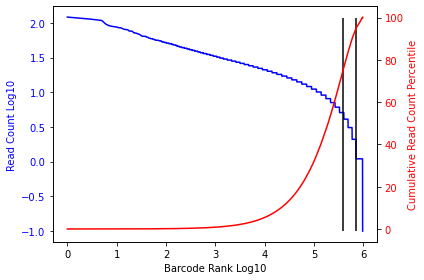

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 1
Finished processing sample BB_RT_3_340_243_Hek1055
Processing sample BB_RT_3_340_335_Cos1055
processed 1000 bcs, 6706 reads
processed 2000 bcs, 13957 reads
processed 3000 bcs, 20587 reads
processed 4000 bcs, 27677 reads
processed 5000 bcs, 34684 reads
processed 6000 bcs, 41089 reads
processed 7000 bcs, 48242 reads
processed 8000 bcs, 54129 reads
processed 9000 bcs, 61648 reads
processed 10000 bcs, 68439 reads
processed 11000 bcs, 78100 reads
processed 12000 bcs, 86496 reads
processed 13000 bcs, 93699 reads
processed 14000 bcs, 101271 reads
processed 15000 bcs, 108863 reads
processed 16000 bcs, 116037 reads
processed 17000 bcs, 123379 reads
processed 18000 bcs, 130685 reads
processed 19000 bcs, 139031 reads
processed 20000 bcs, 148131 reads
processed 21000 bcs, 155818 reads
processed 22000 bcs, 162542 reads
processed 23000 bcs, 170587 reads
processed 24000 bcs, 178818 reads
processed 

processed 232000 bcs, 1704485 reads
processed 233000 bcs, 1713106 reads
processed 234000 bcs, 1721094 reads
processed 235000 bcs, 1729198 reads
processed 236000 bcs, 1737522 reads
processed 237000 bcs, 1745984 reads
processed 238000 bcs, 1753680 reads
processed 239000 bcs, 1762700 reads
processed 240000 bcs, 1771393 reads
processed 241000 bcs, 1781061 reads
processed 242000 bcs, 1791401 reads
processed 243000 bcs, 1799810 reads
processed 244000 bcs, 1806726 reads
processed 245000 bcs, 1814787 reads
processed 246000 bcs, 1822556 reads
processed 247000 bcs, 1830935 reads
processed 248000 bcs, 1838284 reads
processed 249000 bcs, 1846987 reads
processed 250000 bcs, 1857670 reads
processed 251000 bcs, 1868387 reads
processed 252000 bcs, 1875554 reads
processed 253000 bcs, 1882381 reads
processed 254000 bcs, 1889673 reads
processed 255000 bcs, 1897644 reads
processed 256000 bcs, 1905486 reads
processed 257000 bcs, 1913107 reads
processed 258000 bcs, 1920844 reads
processed 259000 bcs, 193118

processed 462000 bcs, 3624788 reads
processed 463000 bcs, 3630287 reads
processed 464000 bcs, 3636265 reads
processed 465000 bcs, 3643375 reads
processed 466000 bcs, 3649292 reads
processed 467000 bcs, 3654754 reads
processed 468000 bcs, 3660780 reads
processed 469000 bcs, 3666642 reads
processed 470000 bcs, 3672938 reads
processed 471000 bcs, 3678903 reads
processed 472000 bcs, 3684847 reads
processed 473000 bcs, 3691064 reads
processed 474000 bcs, 3697840 reads
processed 475000 bcs, 3703792 reads
processed 476000 bcs, 3710655 reads
processed 477000 bcs, 3715852 reads
processed 478000 bcs, 3722066 reads
processed 479000 bcs, 3727903 reads
processed 480000 bcs, 3733102 reads
processed 481000 bcs, 3738284 reads
processed 482000 bcs, 3745944 reads
processed 483000 bcs, 3754916 reads
processed 484000 bcs, 3767317 reads
processed 485000 bcs, 3776048 reads
processed 486000 bcs, 3784882 reads
processed 487000 bcs, 3791808 reads
processed 488000 bcs, 3800039 reads
processed 489000 bcs, 380711

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


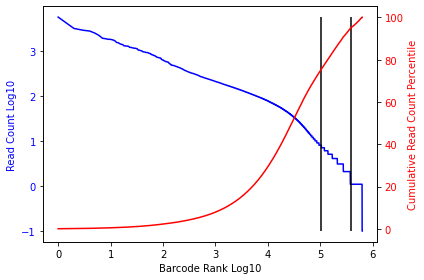

The read count cut off at the 75 th percentile is 8
The read count cut off at the 95 th percentile is 1
Finished processing sample BB_RT_3_340_335_Cos1055
Processing sample BB_RT_3_340_335_Hek1055
processed 1000 bcs, 6541 reads
processed 2000 bcs, 13693 reads
processed 3000 bcs, 19748 reads
processed 4000 bcs, 26414 reads
processed 5000 bcs, 33401 reads
processed 6000 bcs, 40447 reads
processed 7000 bcs, 47009 reads
processed 8000 bcs, 54280 reads
processed 9000 bcs, 59753 reads
processed 10000 bcs, 65404 reads
processed 11000 bcs, 72661 reads
processed 12000 bcs, 78716 reads
processed 13000 bcs, 84355 reads
processed 14000 bcs, 91527 reads
processed 15000 bcs, 97961 reads
processed 16000 bcs, 104287 reads
processed 17000 bcs, 112063 reads
processed 18000 bcs, 119687 reads
processed 19000 bcs, 126915 reads
processed 20000 bcs, 134146 reads
processed 21000 bcs, 140842 reads
processed 22000 bcs, 147575 reads
processed 23000 bcs, 153939 reads
processed 24000 bcs, 161945 reads
processed 25

processed 231000 bcs, 1572286 reads
processed 232000 bcs, 1578370 reads
processed 233000 bcs, 1583912 reads
processed 234000 bcs, 1590545 reads
processed 235000 bcs, 1597019 reads
processed 236000 bcs, 1602469 reads
processed 237000 bcs, 1608213 reads
processed 238000 bcs, 1613850 reads
processed 239000 bcs, 1620905 reads
processed 240000 bcs, 1627975 reads
processed 241000 bcs, 1635495 reads
processed 242000 bcs, 1642989 reads
processed 243000 bcs, 1650155 reads
processed 244000 bcs, 1656940 reads
processed 245000 bcs, 1664696 reads
processed 246000 bcs, 1671831 reads
processed 247000 bcs, 1679566 reads
processed 248000 bcs, 1687766 reads
processed 249000 bcs, 1694683 reads
processed 250000 bcs, 1701168 reads
processed 251000 bcs, 1708068 reads
processed 252000 bcs, 1714492 reads
processed 253000 bcs, 1720552 reads
processed 254000 bcs, 1726925 reads
processed 255000 bcs, 1732357 reads
processed 256000 bcs, 1738642 reads
processed 257000 bcs, 1745250 reads
processed 258000 bcs, 175229

processed 459000 bcs, 3126018 reads
processed 460000 bcs, 3135127 reads
processed 461000 bcs, 3144608 reads
processed 462000 bcs, 3154090 reads
processed 463000 bcs, 3163514 reads
processed 464000 bcs, 3172213 reads
processed 465000 bcs, 3180242 reads
processed 466000 bcs, 3190257 reads
processed 467000 bcs, 3199108 reads
processed 468000 bcs, 3208492 reads
processed 469000 bcs, 3216818 reads
processed 470000 bcs, 3225194 reads
processed 471000 bcs, 3232495 reads
processed 472000 bcs, 3240474 reads
processed 473000 bcs, 3248034 reads
processed 474000 bcs, 3257583 reads
processed 475000 bcs, 3266484 reads
processed 476000 bcs, 3274979 reads
processed 477000 bcs, 3285161 reads
processed 478000 bcs, 3293061 reads
processed 479000 bcs, 3301894 reads
processed 480000 bcs, 3309662 reads
processed 481000 bcs, 3318620 reads
processed 482000 bcs, 3327087 reads
processed 483000 bcs, 3334602 reads
processed 484000 bcs, 3342448 reads
processed 485000 bcs, 3350155 reads
processed 486000 bcs, 335967

processed 689000 bcs, 4829803 reads
processed 690000 bcs, 4834596 reads
processed 691000 bcs, 4840365 reads
processed 692000 bcs, 4846717 reads
processed 693000 bcs, 4852292 reads
processed 694000 bcs, 4858255 reads
processed 695000 bcs, 4865503 reads
processed 696000 bcs, 4872236 reads
processed 697000 bcs, 4878338 reads
processed 698000 bcs, 4884728 reads
processed 699000 bcs, 4890702 reads
processed 700000 bcs, 4896825 reads
processed 701000 bcs, 4902337 reads
processed 702000 bcs, 4907639 reads
processed 703000 bcs, 4913128 reads
processed 704000 bcs, 4919001 reads
processed 705000 bcs, 4924791 reads
processed 706000 bcs, 4930984 reads
processed 707000 bcs, 4936311 reads
processed 708000 bcs, 4941829 reads
processed 709000 bcs, 4948078 reads
processed 710000 bcs, 4953983 reads
processed 711000 bcs, 4960549 reads
processed 712000 bcs, 4967397 reads
processed 713000 bcs, 4974176 reads
processed 714000 bcs, 4980827 reads
processed 715000 bcs, 4989238 reads
processed 716000 bcs, 499541

processed 919000 bcs, 6317654 reads
processed 920000 bcs, 6323330 reads
processed 921000 bcs, 6329014 reads
processed 922000 bcs, 6334536 reads
processed 923000 bcs, 6340170 reads
processed 924000 bcs, 6344642 reads
processed 925000 bcs, 6349395 reads
processed 926000 bcs, 6354668 reads
processed 927000 bcs, 6359832 reads
processed 928000 bcs, 6365368 reads
processed 929000 bcs, 6370273 reads
processed 930000 bcs, 6376867 reads
processed 931000 bcs, 6382307 reads
processed 932000 bcs, 6387062 reads
processed 933000 bcs, 6392989 reads
processed 934000 bcs, 6398240 reads
processed 935000 bcs, 6403375 reads
processed 936000 bcs, 6409876 reads
processed 937000 bcs, 6415811 reads
processed 938000 bcs, 6421936 reads
processed 939000 bcs, 6427542 reads
processed 940000 bcs, 6434854 reads
processed 941000 bcs, 6441526 reads
processed 942000 bcs, 6447921 reads
processed 943000 bcs, 6455376 reads
processed 944000 bcs, 6462868 reads
processed 945000 bcs, 6470474 reads
processed 946000 bcs, 647738

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


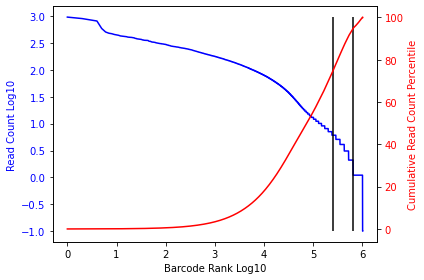

The read count cut off at the 75 th percentile is 6
The read count cut off at the 95 th percentile is 1
Finished processing sample BB_RT_3_340_335_Hek1055
Processing sample BB_RT_3_ODT_243_Cos1055
processed 1000 bcs, 6409 reads
processed 2000 bcs, 13161 reads
processed 3000 bcs, 19497 reads
processed 4000 bcs, 26399 reads
processed 5000 bcs, 33017 reads
processed 6000 bcs, 39958 reads
processed 7000 bcs, 47089 reads
processed 8000 bcs, 54055 reads
processed 9000 bcs, 60203 reads
processed 10000 bcs, 66830 reads
processed 11000 bcs, 73401 reads
processed 12000 bcs, 79553 reads
processed 13000 bcs, 85721 reads
processed 14000 bcs, 92746 reads
processed 15000 bcs, 99393 reads
processed 16000 bcs, 106704 reads
processed 17000 bcs, 114234 reads
processed 18000 bcs, 121155 reads
processed 19000 bcs, 128149 reads
processed 20000 bcs, 135081 reads
processed 21000 bcs, 141413 reads
processed 22000 bcs, 148381 reads
processed 23000 bcs, 155700 reads
processed 24000 bcs, 163045 reads
processed 25

processed 231000 bcs, 1568011 reads
processed 232000 bcs, 1575055 reads
processed 233000 bcs, 1581519 reads
processed 234000 bcs, 1588063 reads
processed 235000 bcs, 1594576 reads
processed 236000 bcs, 1601367 reads
processed 237000 bcs, 1607457 reads
processed 238000 bcs, 1613013 reads
processed 239000 bcs, 1619551 reads
processed 240000 bcs, 1626827 reads
processed 241000 bcs, 1634038 reads
processed 242000 bcs, 1640473 reads
processed 243000 bcs, 1647261 reads
processed 244000 bcs, 1653392 reads
processed 245000 bcs, 1659756 reads
processed 246000 bcs, 1665785 reads
processed 247000 bcs, 1671528 reads
processed 248000 bcs, 1678613 reads
processed 249000 bcs, 1686289 reads
processed 250000 bcs, 1692625 reads
processed 251000 bcs, 1698823 reads
processed 252000 bcs, 1705169 reads
processed 253000 bcs, 1711810 reads
processed 254000 bcs, 1717884 reads
processed 255000 bcs, 1724467 reads
processed 256000 bcs, 1730731 reads
processed 257000 bcs, 1737594 reads
processed 258000 bcs, 174426

processed 459000 bcs, 3164470 reads
processed 460000 bcs, 3171742 reads
processed 461000 bcs, 3179726 reads
processed 462000 bcs, 3186789 reads
processed 463000 bcs, 3194261 reads
processed 464000 bcs, 3201830 reads
processed 465000 bcs, 3208609 reads
processed 466000 bcs, 3215493 reads
processed 467000 bcs, 3222390 reads
processed 468000 bcs, 3229621 reads
processed 469000 bcs, 3237311 reads
processed 470000 bcs, 3245775 reads
processed 471000 bcs, 3253479 reads
processed 472000 bcs, 3261111 reads
processed 473000 bcs, 3268955 reads
processed 474000 bcs, 3276843 reads
processed 475000 bcs, 3286601 reads
processed 476000 bcs, 3294575 reads
processed 477000 bcs, 3302243 reads
processed 478000 bcs, 3309770 reads
processed 479000 bcs, 3316893 reads
processed 480000 bcs, 3324427 reads
processed 481000 bcs, 3332411 reads
processed 482000 bcs, 3339573 reads
processed 483000 bcs, 3346813 reads
processed 484000 bcs, 3355096 reads
processed 485000 bcs, 3362799 reads
processed 486000 bcs, 337073

processed 688000 bcs, 4756538 reads
processed 689000 bcs, 4762244 reads
processed 690000 bcs, 4768532 reads
processed 691000 bcs, 4774484 reads
processed 692000 bcs, 4780170 reads
processed 693000 bcs, 4785945 reads
processed 694000 bcs, 4792288 reads
processed 695000 bcs, 4798264 reads
processed 696000 bcs, 4804123 reads
processed 697000 bcs, 4810143 reads
processed 698000 bcs, 4815989 reads
processed 699000 bcs, 4822253 reads
processed 700000 bcs, 4829057 reads
processed 701000 bcs, 4836035 reads
processed 702000 bcs, 4842584 reads
processed 703000 bcs, 4849351 reads
processed 704000 bcs, 4855489 reads
processed 705000 bcs, 4862141 reads
processed 706000 bcs, 4869144 reads
processed 707000 bcs, 4875197 reads
processed 708000 bcs, 4881152 reads
processed 709000 bcs, 4887204 reads
processed 710000 bcs, 4893141 reads
processed 711000 bcs, 4899107 reads
processed 712000 bcs, 4904753 reads
processed 713000 bcs, 4911571 reads
processed 714000 bcs, 4917890 reads
processed 715000 bcs, 492399

processed 916000 bcs, 6285656 reads
processed 917000 bcs, 6291987 reads
processed 918000 bcs, 6298227 reads
processed 919000 bcs, 6304215 reads
processed 920000 bcs, 6310789 reads
processed 921000 bcs, 6318047 reads
processed 922000 bcs, 6324875 reads
processed 923000 bcs, 6331742 reads
processed 924000 bcs, 6337629 reads
processed 925000 bcs, 6343853 reads
processed 926000 bcs, 6350221 reads
processed 927000 bcs, 6356826 reads
processed 928000 bcs, 6363294 reads
processed 929000 bcs, 6369738 reads
processed 930000 bcs, 6375493 reads
processed 931000 bcs, 6381887 reads
processed 932000 bcs, 6387685 reads
processed 933000 bcs, 6393916 reads
processed 934000 bcs, 6400141 reads
processed 935000 bcs, 6405910 reads
processed 936000 bcs, 6411640 reads
processed 937000 bcs, 6418202 reads
processed 938000 bcs, 6423792 reads
processed 939000 bcs, 6430289 reads
processed 940000 bcs, 6437415 reads
processed 941000 bcs, 6444872 reads
processed 942000 bcs, 6451521 reads
processed 943000 bcs, 645876

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


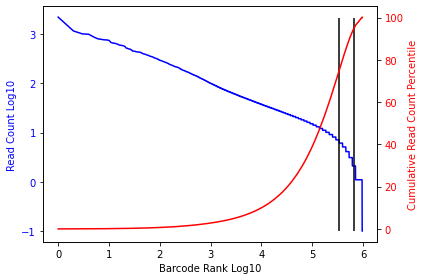

The read count cut off at the 75 th percentile is 7
The read count cut off at the 95 th percentile is 2
Finished processing sample BB_RT_3_ODT_243_Cos1055
Processing sample BB_RT_3_ODT_243_Hek1055
processed 1000 bcs, 3970 reads
processed 2000 bcs, 7758 reads
processed 3000 bcs, 11708 reads
processed 4000 bcs, 16054 reads
processed 5000 bcs, 20385 reads
processed 6000 bcs, 24668 reads
processed 7000 bcs, 28662 reads
processed 8000 bcs, 32372 reads
processed 9000 bcs, 36263 reads
processed 10000 bcs, 40290 reads
processed 11000 bcs, 43840 reads
processed 12000 bcs, 47891 reads
processed 13000 bcs, 51948 reads
processed 14000 bcs, 56300 reads
processed 15000 bcs, 60844 reads
processed 16000 bcs, 65088 reads
processed 17000 bcs, 69208 reads
processed 18000 bcs, 73352 reads
processed 19000 bcs, 77335 reads
processed 20000 bcs, 81767 reads
processed 21000 bcs, 85992 reads
processed 22000 bcs, 90298 reads
processed 23000 bcs, 94649 reads
processed 24000 bcs, 99050 reads
processed 25000 bcs, 1

processed 235000 bcs, 944718 reads
processed 236000 bcs, 948162 reads
processed 237000 bcs, 951457 reads
processed 238000 bcs, 955522 reads
processed 239000 bcs, 959216 reads
processed 240000 bcs, 962644 reads
processed 241000 bcs, 966058 reads
processed 242000 bcs, 969424 reads
processed 243000 bcs, 972832 reads
processed 244000 bcs, 976418 reads
processed 245000 bcs, 980284 reads
processed 246000 bcs, 984123 reads
processed 247000 bcs, 988429 reads
processed 248000 bcs, 992462 reads
processed 249000 bcs, 996470 reads
processed 250000 bcs, 999863 reads
processed 251000 bcs, 1003568 reads
processed 252000 bcs, 1006904 reads
processed 253000 bcs, 1010765 reads
processed 254000 bcs, 1015072 reads
processed 255000 bcs, 1019282 reads
processed 256000 bcs, 1023328 reads
processed 257000 bcs, 1026820 reads
processed 258000 bcs, 1030740 reads
processed 259000 bcs, 1034639 reads
processed 260000 bcs, 1038512 reads
processed 261000 bcs, 1042876 reads
processed 262000 bcs, 1046929 reads
processe

processed 465000 bcs, 1904179 reads
processed 466000 bcs, 1908572 reads
processed 467000 bcs, 1912659 reads
processed 468000 bcs, 1916619 reads
processed 469000 bcs, 1920321 reads
processed 470000 bcs, 1924368 reads
processed 471000 bcs, 1928508 reads
processed 472000 bcs, 1932793 reads
processed 473000 bcs, 1936904 reads
processed 474000 bcs, 1940910 reads
processed 475000 bcs, 1945100 reads
processed 476000 bcs, 1948972 reads
processed 477000 bcs, 1952867 reads
processed 478000 bcs, 1957070 reads
processed 479000 bcs, 1961120 reads
processed 480000 bcs, 1964374 reads
processed 481000 bcs, 1968334 reads
processed 482000 bcs, 1972270 reads
processed 483000 bcs, 1976499 reads
processed 484000 bcs, 1980759 reads
processed 485000 bcs, 1984956 reads
processed 486000 bcs, 1988973 reads
processed 487000 bcs, 1992692 reads
processed 488000 bcs, 1996740 reads
processed 489000 bcs, 2000255 reads
processed 490000 bcs, 2003849 reads
processed 491000 bcs, 2007413 reads
processed 492000 bcs, 201135

processed 695000 bcs, 2826670 reads
processed 696000 bcs, 2831134 reads
processed 697000 bcs, 2835591 reads
processed 698000 bcs, 2839671 reads
processed 699000 bcs, 2843789 reads
processed 700000 bcs, 2848006 reads
processed 701000 bcs, 2851866 reads
processed 702000 bcs, 2855600 reads
processed 703000 bcs, 2859227 reads
processed 704000 bcs, 2863067 reads
processed 705000 bcs, 2867202 reads
processed 706000 bcs, 2871325 reads
processed 707000 bcs, 2875461 reads
processed 708000 bcs, 2879352 reads
processed 709000 bcs, 2883296 reads
processed 710000 bcs, 2887171 reads
processed 711000 bcs, 2891441 reads
processed 712000 bcs, 2895565 reads
processed 713000 bcs, 2899791 reads
processed 714000 bcs, 2904201 reads
processed 715000 bcs, 2908506 reads
processed 716000 bcs, 2912984 reads
processed 717000 bcs, 2917097 reads
processed 718000 bcs, 2921101 reads
processed 719000 bcs, 2925442 reads
processed 720000 bcs, 2929770 reads
processed 721000 bcs, 2933849 reads
processed 722000 bcs, 293778

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


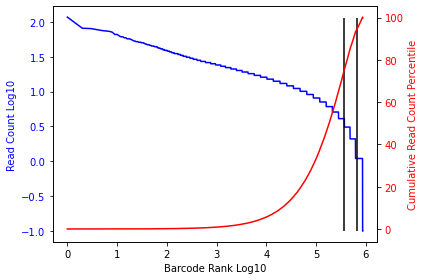

The read count cut off at the 75 th percentile is 4
The read count cut off at the 95 th percentile is 1
Finished processing sample BB_RT_3_ODT_243_Hek1055
Processing sample BB_RT_3_ODT_335_cos1055
processed 1000 bcs, 8012 reads
processed 2000 bcs, 16105 reads
processed 3000 bcs, 25012 reads
processed 4000 bcs, 33363 reads
processed 5000 bcs, 41142 reads
processed 6000 bcs, 49860 reads
processed 7000 bcs, 58877 reads
processed 8000 bcs, 66891 reads
processed 9000 bcs, 75145 reads
processed 10000 bcs, 84502 reads
processed 11000 bcs, 95139 reads
processed 12000 bcs, 105226 reads
processed 13000 bcs, 115794 reads
processed 14000 bcs, 125077 reads
processed 15000 bcs, 134399 reads
processed 16000 bcs, 144389 reads
processed 17000 bcs, 152484 reads
processed 18000 bcs, 161563 reads
processed 19000 bcs, 170312 reads
processed 20000 bcs, 180605 reads
processed 21000 bcs, 192934 reads
processed 22000 bcs, 202524 reads
processed 23000 bcs, 211229 reads
processed 24000 bcs, 221574 reads
processe

processed 231000 bcs, 2118563 reads
processed 232000 bcs, 2125953 reads
processed 233000 bcs, 2133523 reads
processed 234000 bcs, 2140340 reads
processed 235000 bcs, 2148198 reads
processed 236000 bcs, 2157064 reads
processed 237000 bcs, 2164262 reads
processed 238000 bcs, 2173674 reads
processed 239000 bcs, 2180208 reads
processed 240000 bcs, 2187491 reads
processed 241000 bcs, 2196125 reads
processed 242000 bcs, 2207320 reads
processed 243000 bcs, 2217873 reads
processed 244000 bcs, 2228481 reads
processed 245000 bcs, 2240750 reads
processed 246000 bcs, 2250618 reads
processed 247000 bcs, 2260908 reads
processed 248000 bcs, 2272612 reads
processed 249000 bcs, 2283078 reads
processed 250000 bcs, 2293630 reads
processed 251000 bcs, 2302583 reads
processed 252000 bcs, 2312832 reads
processed 253000 bcs, 2323273 reads
processed 254000 bcs, 2334143 reads
processed 255000 bcs, 2345559 reads
processed 256000 bcs, 2357701 reads
processed 257000 bcs, 2370395 reads
processed 258000 bcs, 238158

processed 459000 bcs, 4580317 reads
processed 460000 bcs, 4589673 reads
processed 461000 bcs, 4600163 reads
processed 462000 bcs, 4609862 reads
processed 463000 bcs, 4620809 reads
processed 464000 bcs, 4629408 reads
processed 465000 bcs, 4638878 reads
processed 466000 bcs, 4646240 reads
processed 467000 bcs, 4653985 reads
processed 468000 bcs, 4661779 reads
processed 469000 bcs, 4670391 reads
processed 470000 bcs, 4679377 reads
processed 471000 bcs, 4686797 reads
processed 472000 bcs, 4696439 reads
processed 473000 bcs, 4703233 reads
processed 474000 bcs, 4710816 reads
processed 475000 bcs, 4719139 reads
processed 476000 bcs, 4727592 reads
processed 477000 bcs, 4735699 reads
processed 478000 bcs, 4744110 reads
processed 479000 bcs, 4752195 reads
processed 480000 bcs, 4762221 reads
processed 481000 bcs, 4773720 reads
processed 482000 bcs, 4782529 reads
processed 483000 bcs, 4792120 reads
processed 484000 bcs, 4801755 reads
processed 485000 bcs, 4810293 reads
processed 486000 bcs, 481846

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


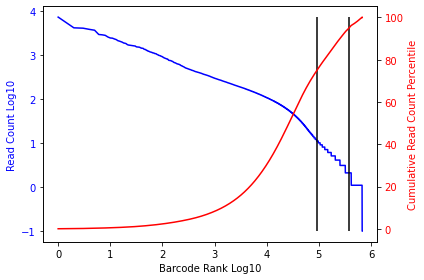

The read count cut off at the 75 th percentile is 11
The read count cut off at the 95 th percentile is 2
Finished processing sample BB_RT_3_ODT_335_cos1055
Processing sample BB_RT_3_ODT_335_Hek1055
processed 1000 bcs, 5191 reads
processed 2000 bcs, 10908 reads
processed 3000 bcs, 16230 reads
processed 4000 bcs, 21646 reads
processed 5000 bcs, 27310 reads
processed 6000 bcs, 32716 reads
processed 7000 bcs, 38234 reads
processed 8000 bcs, 42883 reads
processed 9000 bcs, 48305 reads
processed 10000 bcs, 53422 reads
processed 11000 bcs, 58184 reads
processed 12000 bcs, 63998 reads
processed 13000 bcs, 69641 reads
processed 14000 bcs, 74908 reads
processed 15000 bcs, 81669 reads
processed 16000 bcs, 87984 reads
processed 17000 bcs, 93772 reads
processed 18000 bcs, 99367 reads
processed 19000 bcs, 105170 reads
processed 20000 bcs, 111549 reads
processed 21000 bcs, 117190 reads
processed 22000 bcs, 123063 reads
processed 23000 bcs, 128834 reads
processed 24000 bcs, 134334 reads
processed 2500

processed 233000 bcs, 1300895 reads
processed 234000 bcs, 1305482 reads
processed 235000 bcs, 1310546 reads
processed 236000 bcs, 1315954 reads
processed 237000 bcs, 1320873 reads
processed 238000 bcs, 1324447 reads
processed 239000 bcs, 1328325 reads
processed 240000 bcs, 1332436 reads
processed 241000 bcs, 1336453 reads
processed 242000 bcs, 1342223 reads
processed 243000 bcs, 1347412 reads
processed 244000 bcs, 1351835 reads
processed 245000 bcs, 1356147 reads
processed 246000 bcs, 1360481 reads
processed 247000 bcs, 1364687 reads
processed 248000 bcs, 1369141 reads
processed 249000 bcs, 1374388 reads
processed 250000 bcs, 1379685 reads
processed 251000 bcs, 1385716 reads
processed 252000 bcs, 1390729 reads
processed 253000 bcs, 1395425 reads
processed 254000 bcs, 1399855 reads
processed 255000 bcs, 1404154 reads
processed 256000 bcs, 1408685 reads
processed 257000 bcs, 1414163 reads
processed 258000 bcs, 1420506 reads
processed 259000 bcs, 1426521 reads
processed 260000 bcs, 143172

processed 462000 bcs, 2666733 reads
processed 463000 bcs, 2673075 reads
processed 464000 bcs, 2677877 reads
processed 465000 bcs, 2682946 reads
processed 466000 bcs, 2687699 reads
processed 467000 bcs, 2694004 reads
processed 468000 bcs, 2700010 reads
processed 469000 bcs, 2706161 reads
processed 470000 bcs, 2712036 reads
processed 471000 bcs, 2718971 reads
processed 472000 bcs, 2725146 reads
processed 473000 bcs, 2732002 reads
processed 474000 bcs, 2738510 reads
processed 475000 bcs, 2744323 reads
processed 476000 bcs, 2749615 reads
processed 477000 bcs, 2756368 reads
processed 478000 bcs, 2762723 reads
processed 479000 bcs, 2768655 reads
processed 480000 bcs, 2773736 reads
processed 481000 bcs, 2780246 reads
processed 482000 bcs, 2786364 reads
processed 483000 bcs, 2792822 reads
processed 484000 bcs, 2798498 reads
processed 485000 bcs, 2803863 reads
processed 486000 bcs, 2809801 reads
processed 487000 bcs, 2815040 reads
processed 488000 bcs, 2819737 reads
processed 489000 bcs, 282572

processed 691000 bcs, 3960744 reads
processed 692000 bcs, 3965781 reads
processed 693000 bcs, 3970847 reads
processed 694000 bcs, 3976252 reads
processed 695000 bcs, 3982475 reads
processed 696000 bcs, 3988512 reads
processed 697000 bcs, 3993864 reads
processed 698000 bcs, 4000133 reads
processed 699000 bcs, 4005756 reads
processed 700000 bcs, 4010859 reads
processed 701000 bcs, 4015580 reads
processed 702000 bcs, 4021341 reads
processed 703000 bcs, 4025922 reads
processed 704000 bcs, 4030301 reads
processed 705000 bcs, 4036228 reads
processed 706000 bcs, 4043422 reads
processed 707000 bcs, 4049457 reads
processed 708000 bcs, 4055297 reads
processed 709000 bcs, 4060958 reads
processed 710000 bcs, 4067376 reads
processed 711000 bcs, 4073093 reads
processed 712000 bcs, 4078502 reads
processed 713000 bcs, 4084206 reads
processed 714000 bcs, 4090382 reads
processed 715000 bcs, 4095131 reads
processed 716000 bcs, 4100175 reads
processed 717000 bcs, 4105015 reads
processed 718000 bcs, 411043

/home/smithcat/miniconda3/envs/splai3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


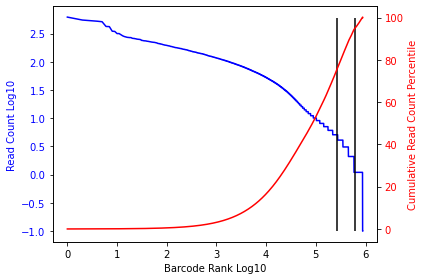

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 1
Finished processing sample BB_RT_3_ODT_335_Hek1055
CPU times: user 2h 4min 32s, sys: 2min 40s, total: 2h 7min 13s
Wall time: 2h 7min 13s


In [59]:
%%time
msamp_bcs_processed = { lib: { samp: process_bcs_wrapper( samp,
                                                          msamp_rnabam[ samp ],
                                                          isogrpdict_allsamp,
                                                          namedisogrps[ samp ],
                                                          [ ( 649, 696 ), ( 3478, 3533 ) ],
                                                          satbl_fn[ lib ],
                                                          spl_tol = 3,
                                                          indel_tol = 20,
                                                          min_matches_for = 70,
                                                          min_matches_rev = 50,
                                                          other_isos_usable = False,
                                                          bc_tag = 'BC',
                                                          max_bc_len = 30,
                                                          unmapped_pysam = unmap_mate1_fn[ samp ], )
                                  for samp in msamp_rnabam if lib.replace( 'JKP', '' ) in samp }
                        for lib in satbl_fn }

In [65]:
#now in junction scorer!
def create_read_count_df( bysamp_bc_dict,
                          thresholds,
                          read_cutoff_key = 'bc_read_cutoffs' ):
    
    out_dict = { 'sample': [] }
    
    for thresh in thresholds:
        
        out_dict[ str( thresh ) + '_x' ] = []
        out_dict[ str( thresh ) + '_y' ] = []
        
    for samp in bysamp_bc_dict:
        
        out_dict[ 'sample' ].append( samp )
        
        for thresh in thresholds:
            
            out_dict[ str( thresh ) + '_x' ].append( 10**( bysamp_bc_dict[ samp ][ read_cutoff_key ][ 'x' ][ thresh ] ) )
            out_dict[ str( thresh ) + '_y' ].append( bysamp_bc_dict[ samp ][ read_cutoff_key ][ 'y' ][ thresh ] )
    
    outdf = pd.DataFrame( out_dict )
    
    for col in outdf.columns:
    
        if col.endswith( '_x' ):
        
            outdf[ col + '_log10' ] = np.log10( outdf[ col ].tolist() )
            
    return outdf

In [68]:
read_cut_unfilt = pd.concat( [ create_read_count_df( msamp_bcs_processed[ lib ],
                                                    [ 75, 95 ] ) 
                                     for lib in satbl_fn ] )

In [70]:
cut_dict = { samp: cut for samp,cut in zip( read_cut_unfilt[ 'sample' ], read_cut_unfilt[ '95_y' ] ) }

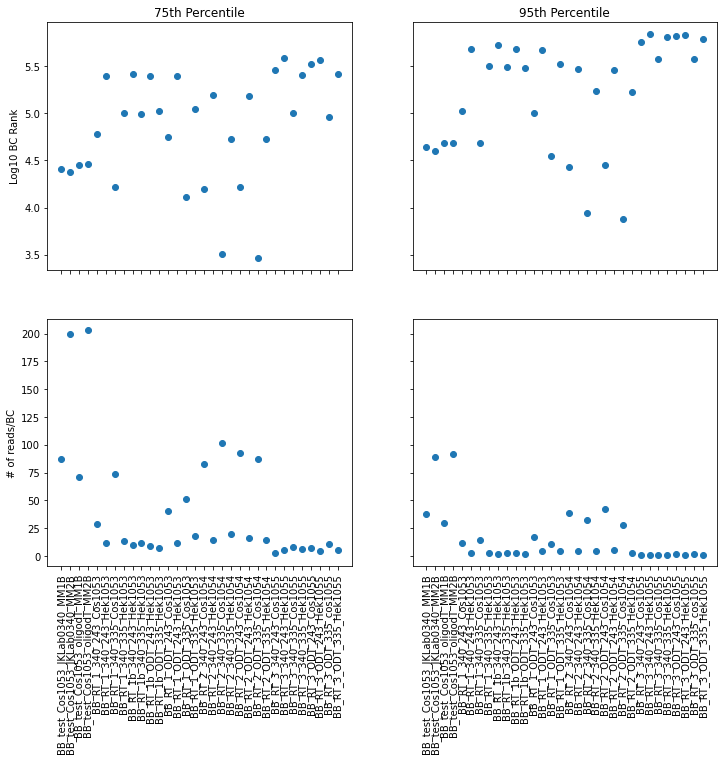

In [71]:
sp.plot_waterfall_bysamp( read_cut_unfilt )

In [72]:
read_cut_unfilt[ 'oligoDT' ] = read_cut_unfilt[ 'sample' ].str.contains( '_ODT_' )

In [73]:
read_cut_unfilt[ 'Hek' ] = read_cut_unfilt[ 'sample' ].str.contains( '_Hek' )

In [74]:
read_cut_unfilt[ '243_synth' ] = read_cut_unfilt[ 'sample' ].str.contains( '_243_' )

In [75]:
read_cut_unfilt[ 'rep' ] = read_cut_unfilt[ 'sample' ].apply( lambda x: x.split( '_' )[ 2 ] )

In [76]:
read_cut_unfilt = read_cut_unfilt.loc[ ~( read_cut_unfilt[ 'sample' ].str.contains( 'test' ) ) ].copy()

In [77]:
read_cut_unfilt[ 'rep_num' ] = [ int( rep ) if rep != '1b' else 4 for rep in read_cut_unfilt.rep
                                 ] 

In [78]:
read_cut_unfilt

,sample,75_x,75_y,95_x,95_y,75_x_log10,95_x_log10,oligoDT,Hek,243_synth,rep,rep_num
4,BB_RT_1_340_243_Cos1053,60139.0,29,107203.0,12,4.779156,5.030207,False,False,True,1,1
5,BB_RT_1_340_243_Hek1053,251344.0,12,479637.0,3,5.400269,5.680913,False,True,True,1,1
6,BB_RT_1_340_335_Cos1053,16576.0,74,47979.0,14,4.219480,4.681051,False,False,False,1,1
7,BB_RT_1_340_335_Hek1053,100484.0,13,319604.0,3,5.002097,5.504612,False,True,False,1,1
8,BB_RT_1b_340_243_Hek1053,261525.0,10,539310.0,2,5.417513,5.731838,False,True,True,1b,4
9,BB_RT_1b_340_335_Hek1053,99628.0,12,312245.0,3,4.998381,5.494495,False,True,False,1b,4
10,BB_RT_1b_ODT_243_Hek1053,251619.0,9,478965.0,3,5.400743,5.680304,True,True,True,1b,4
11,BB_RT_1b_ODT_335_Hek1053,105328.0,7,302899.0,2,5.022544,5.481298,True,True,False,1b,4
12,BB_RT_1_ODT_243_Cos1053,56233.0,40,99895.0,17,4.749991,4.999544,True,False,True,1,1
13,BB_RT_1_ODT_243_Hek1053,251730.0,12,473341.0,4,5.400935,5.675174,True,True,True,1,1


In [79]:
read_cut_unfilt[ 'rep_2' ] = [ rep == 2 for rep in read_cut_unfilt.rep_num ]

In [80]:
read_cut_unfilt[ 'rep_1b' ] = [ rep == 4 for rep in read_cut_unfilt.rep_num ]

In [81]:
read_cut_unfilt[ 'rep_3' ] = [ rep == 3 for rep in read_cut_unfilt.rep_num ]

In [82]:
read_cut_unfilt[ '95_y' ].mean()

8.75

In [83]:
read_cut_unfilt[ '95_y' ].median()

3.0

In [84]:
predictors = [ 'oligoDT', 'Hek', '243_synth', 'rep_1b', 'rep_2', 'rep_3' ]

In [85]:
unfilt_fit = LinearRegression().fit( read_cut_unfilt[ predictors ], read_cut_unfilt[ '95_x' ] ) 

In [86]:
unfilt_fit.coef_

array([  -4311.35714286,  236884.16666667,  121534.35714286,
         52304.91666667, -112217.        ,  343388.25      ])

In [87]:
#so oligoDT results in 4360 fewer BCs,
#there are 237,000 more BCs in HEK cells,
#121,000 more BCs with 243 synthesis,
#rep1b has 52,000 more bcs that rep1
#rep2 has 112,000 fewer bcs than rep1,
#rep3 has 343,000 more bcs than rep1

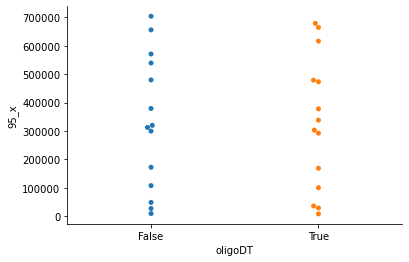

In [88]:
sns.swarmplot( x = 'oligoDT', y = '95_x', data = read_cut_unfilt )
sns.despine()

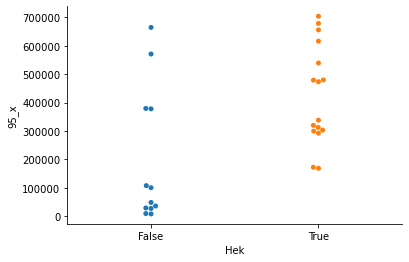

In [89]:
sns.swarmplot( x = 'Hek', y = '95_x', data = read_cut_unfilt )
sns.despine()

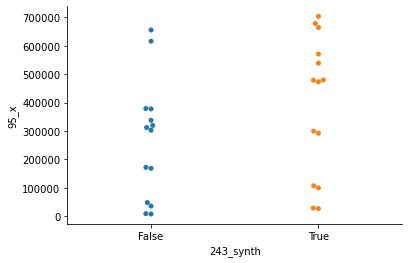

In [90]:
sns.swarmplot( x = '243_synth', y = '95_x', data = read_cut_unfilt )
sns.despine()

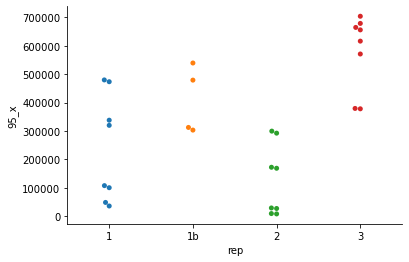

In [91]:
sns.swarmplot( x = 'rep', y = '95_x', data = read_cut_unfilt )
sns.despine()

In [92]:
read_cut_unfilt[ 'primer' ] = [ 'oligoDT' if oligo else '340' for oligo in read_cut_unfilt.oligoDT ]

In [93]:
read_cut_unfilt[ 'cell_type' ] = [ 'HEK' if hek else 'Cos' for hek in read_cut_unfilt.Hek ]

In [94]:
read_cut_unfilt[ 'synthesis' ] = [ '243' if synth else '335' for synth in read_cut_unfilt[ '243_synth' ] ]

In [95]:
read_cut_unfilt.to_csv( bdout + 'n_bcs_bysamp.2022-0926.txt',
                        sep = '\t',
                        index = False )

In [101]:
%%time
for lib in msamp_bcs_processed:

    for samp in msamp_bcs_processed[ lib ]:
    
        msamp_bcs_processed[ lib ][ samp ][ 'msamp_varbcrnatbl_flen_allisos' ].to_csv( bdout + samp + '_wt1_ex9_by_bc_effects_allvars_allisos-2022-0926.txt',
                                                                                       sep = '\t'
                                                                                      )

CPU times: user 1min 45s, sys: 2.41 s, total: 1min 48s
Wall time: 2min 11s


In [102]:
msamp_varbcrnatbl_flen_rename = { lib: { samp: mbcs.merge_subasm_and_rna_tbls( satbl_fn[ lib ],
                                                                               msamp_bcs_processed[ lib ][ samp ][ 'msamp_bcrnatbl_rename' ] )
                                          for samp in msamp_bcs_processed[ lib ] }
                                  for lib in msamp_bcs_processed }

In [103]:
msamp_varbcrnatbl_flen_rename_filt = { lib: { samp: msamp_varbcrnatbl_flen_rename[ lib ][ samp ].loc[ msamp_varbcrnatbl_flen_rename[ lib ][ samp ].usable_reads > cut_dict[ samp ] ].copy()
                                              for samp in msamp_varbcrnatbl_flen_rename[ lib ] } 
                                       for lib in msamp_varbcrnatbl_flen_rename }

In [104]:
%%time
bybcvartbl_filt_long = { lib: mbcs.combine_rep_perbctbls_long( [ msamp_varbcrnatbl_flen_rename_filt[ lib ][ samp ] for samp in msamp_varbcrnatbl_flen_rename_filt[ lib ] ],
                                                               [ samp for samp in msamp_varbcrnatbl_flen_rename_filt[ lib ] ] )
                         for lib in msamp_varbcrnatbl_flen_rename_filt }

CPU times: user 1.27 s, sys: 540 ms, total: 1.81 s
Wall time: 1.81 s


BB_test_Cos1053_JKLab0340_MM1B


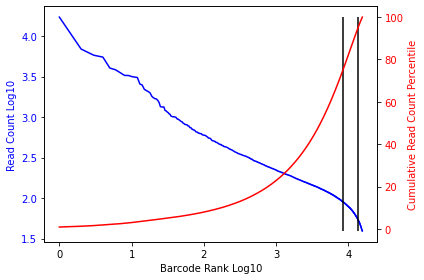

The read count cut off at the 75 th percentile is 90
The read count cut off at the 95 th percentile is 54
BB_test_Cos1053_JKLab0340_MM2B


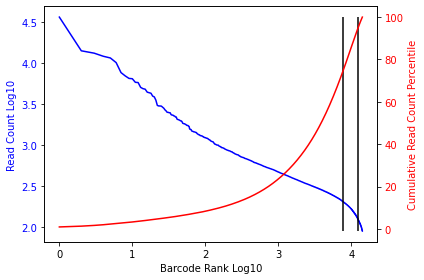

The read count cut off at the 75 th percentile is 204
The read count cut off at the 95 th percentile is 125
BB_test_Cos1053_oligodT_MM1B


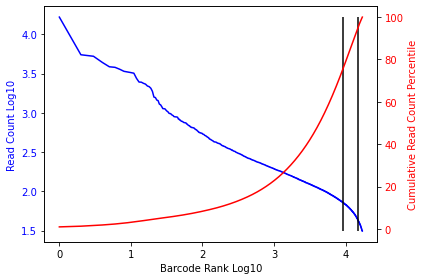

The read count cut off at the 75 th percentile is 72
The read count cut off at the 95 th percentile is 43
BB_test_Cos1053_oligodT_MM2B


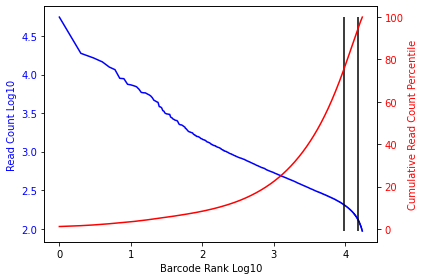

The read count cut off at the 75 th percentile is 206
The read count cut off at the 95 th percentile is 129
BB_RT_1_340_243_Cos1053


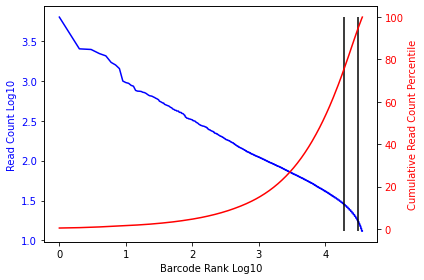

The read count cut off at the 75 th percentile is 29
The read count cut off at the 95 th percentile is 17
BB_RT_1_340_243_Hek1053


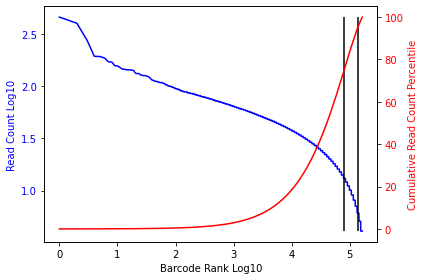

The read count cut off at the 75 th percentile is 13
The read count cut off at the 95 th percentile is 6
BB_RT_1_340_335_Cos1053


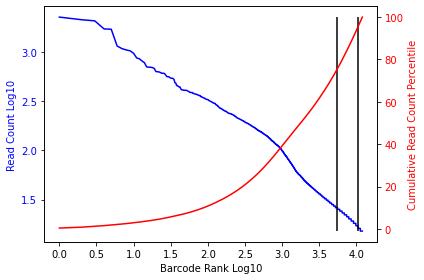

The read count cut off at the 75 th percentile is 26
The read count cut off at the 95 th percentile is 17
BB_RT_1_340_335_Hek1053


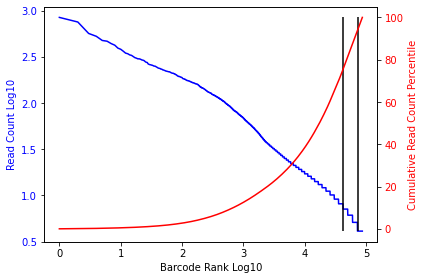

The read count cut off at the 75 th percentile is 8
The read count cut off at the 95 th percentile is 4
BB_RT_1b_340_243_Hek1053


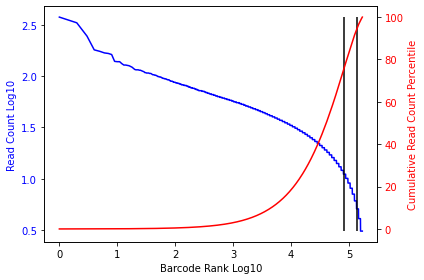

The read count cut off at the 75 th percentile is 11
The read count cut off at the 95 th percentile is 5
BB_RT_1b_340_335_Hek1053


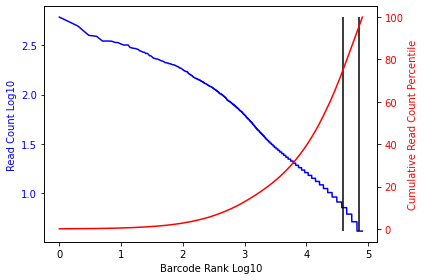

The read count cut off at the 75 th percentile is 7
The read count cut off at the 95 th percentile is 4
BB_RT_1b_ODT_243_Hek1053


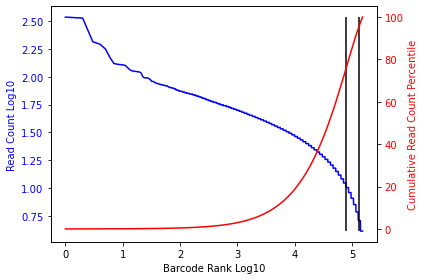

The read count cut off at the 75 th percentile is 11
The read count cut off at the 95 th percentile is 5
BB_RT_1b_ODT_335_Hek1053


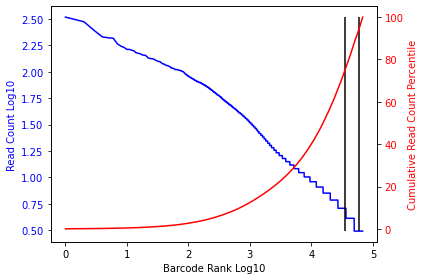

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 3
BB_RT_1_ODT_243_Cos1053


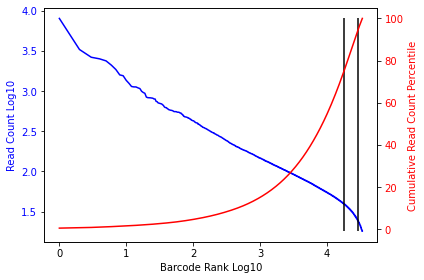

The read count cut off at the 75 th percentile is 39
The read count cut off at the 95 th percentile is 24
BB_RT_1_ODT_243_Hek1053


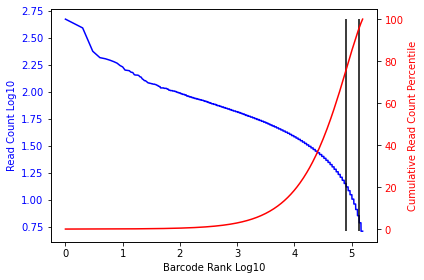

The read count cut off at the 75 th percentile is 14
The read count cut off at the 95 th percentile is 7
BB_RT_1_ODT_335_Cos1053


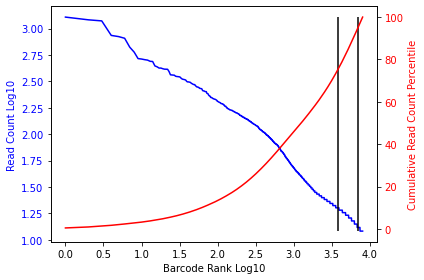

The read count cut off at the 75 th percentile is 20
The read count cut off at the 95 th percentile is 13
BB_RT_1_ODT_335_Hek1053


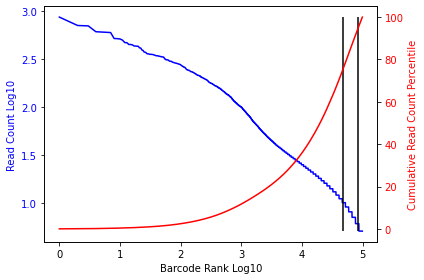

The read count cut off at the 75 th percentile is 10
The read count cut off at the 95 th percentile is 6
BB_RT_2_340_243_Cos1054


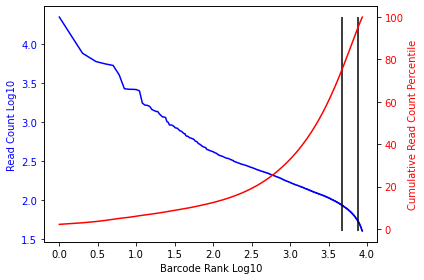

The read count cut off at the 75 th percentile is 86
The read count cut off at the 95 th percentile is 54
BB_RT_2_340_243_Hek1054


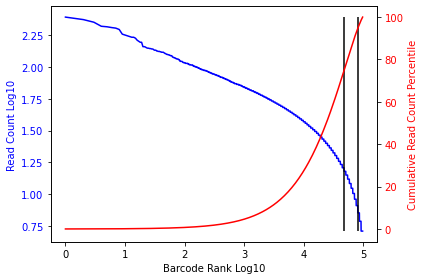

The read count cut off at the 75 th percentile is 15
The read count cut off at the 95 th percentile is 7
BB_RT_2_340_335_Cos1054


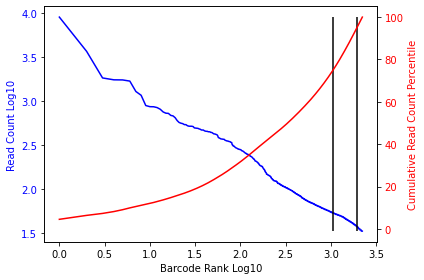

The read count cut off at the 75 th percentile is 53
The read count cut off at the 95 th percentile is 37
BB_RT_2_340_335_Hek1054


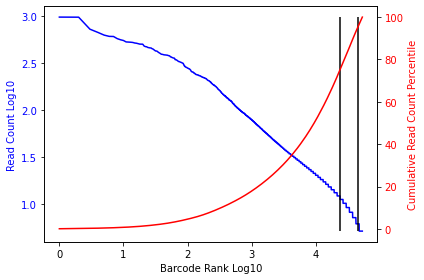

The read count cut off at the 75 th percentile is 12
The read count cut off at the 95 th percentile is 6
BB_RT_2_ODT_243_Cos1054


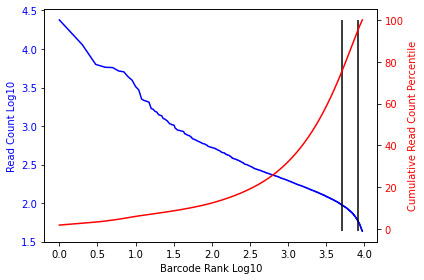

The read count cut off at the 75 th percentile is 95
The read count cut off at the 95 th percentile is 59
BB_RT_2_ODT_243_Hek1054


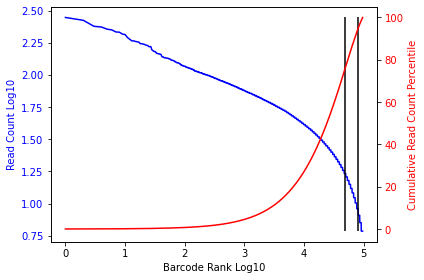

The read count cut off at the 75 th percentile is 17
The read count cut off at the 95 th percentile is 8
BB_RT_2_ODT_335_Cos1054


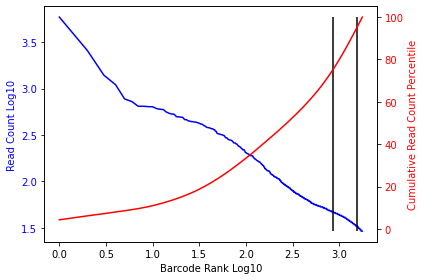

The read count cut off at the 75 th percentile is 47
The read count cut off at the 95 th percentile is 33
BB_RT_2_ODT_335_Hek1054


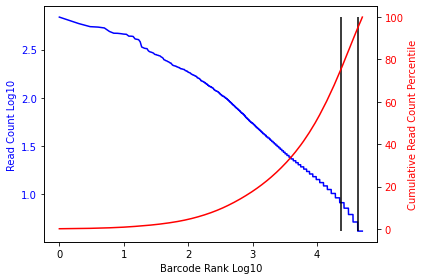

The read count cut off at the 75 th percentile is 8
The read count cut off at the 95 th percentile is 4
BB_RT_3_340_243_Cos1055


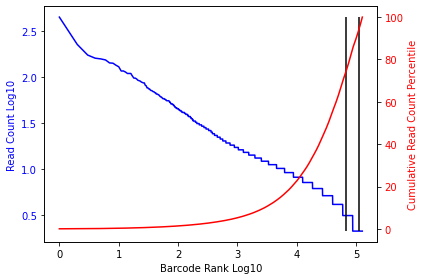

The read count cut off at the 75 th percentile is 3
The read count cut off at the 95 th percentile is 2
BB_RT_3_340_243_Hek1055


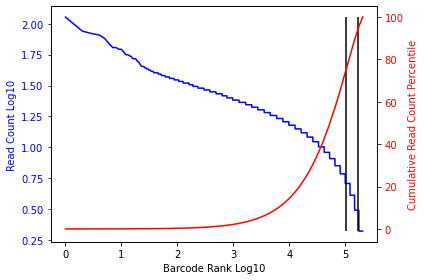

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 3
BB_RT_3_340_335_Cos1055


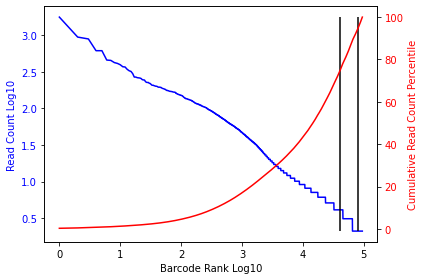

The read count cut off at the 75 th percentile is 4
The read count cut off at the 95 th percentile is 2
BB_RT_3_340_335_Hek1055


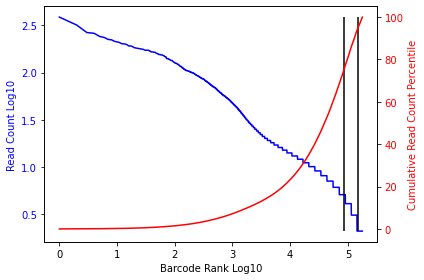

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 2
BB_RT_3_ODT_243_Cos1055


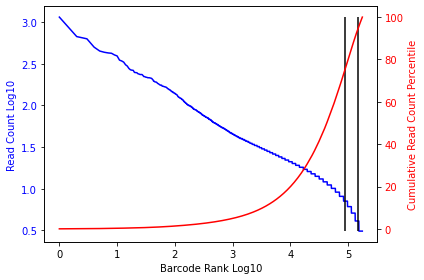

The read count cut off at the 75 th percentile is 7
The read count cut off at the 95 th percentile is 4
BB_RT_3_ODT_243_Hek1055


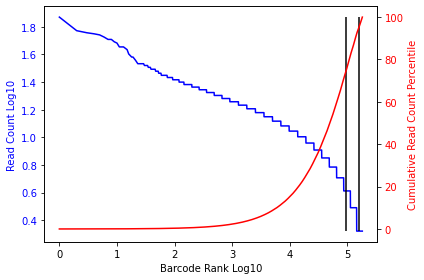

The read count cut off at the 75 th percentile is 4
The read count cut off at the 95 th percentile is 2
BB_RT_3_ODT_335_cos1055


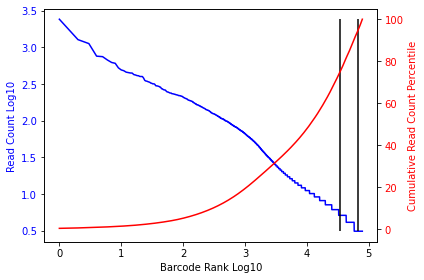

The read count cut off at the 75 th percentile is 5
The read count cut off at the 95 th percentile is 3
BB_RT_3_ODT_335_Hek1055


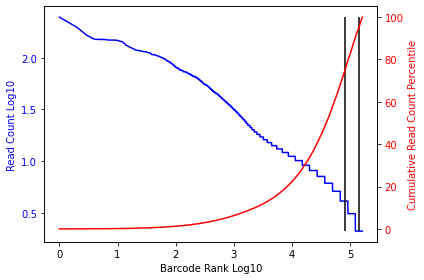

The read count cut off at the 75 th percentile is 4
The read count cut off at the 95 th percentile is 2


In [105]:
read_cut_filt_d = { 'sample': [],
                      '75_x': [],
                      '95_x': [],
                      '75_y': [],
                      '95_y': [], }

for lib in bybcvartbl_filt_long:

    for samp in bybcvartbl_filt_long[ lib ][ 'sample' ].unique():
    
        print( samp )
    
        read_cut_filt_d[ 'sample' ].append( samp )
    
        x_cuts,y_cuts = sp.waterfall_plot( bybcvartbl_filt_long[ lib ].loc[ bybcvartbl_filt_long[ lib ][ 'sample' ] == samp ],
                                           'usable_reads',
                                           [ 75, 95 ] )
    
        for cut in x_cuts:

            read_cut_filt_d[ str( cut ) + '_x' ].append( 10**( x_cuts[ cut ] ) )
            read_cut_filt_d[ str( cut ) + '_y' ].append( y_cuts[ cut ] )

In [106]:
read_cut_filt = pd.DataFrame( read_cut_filt_d )

In [107]:
for col in read_cut_filt.columns:
    
    if col.endswith( '_x' ):
        
        read_cut_filt[ col + '_log10' ] = np.log10( read_cut_filt[ col ].tolist() )

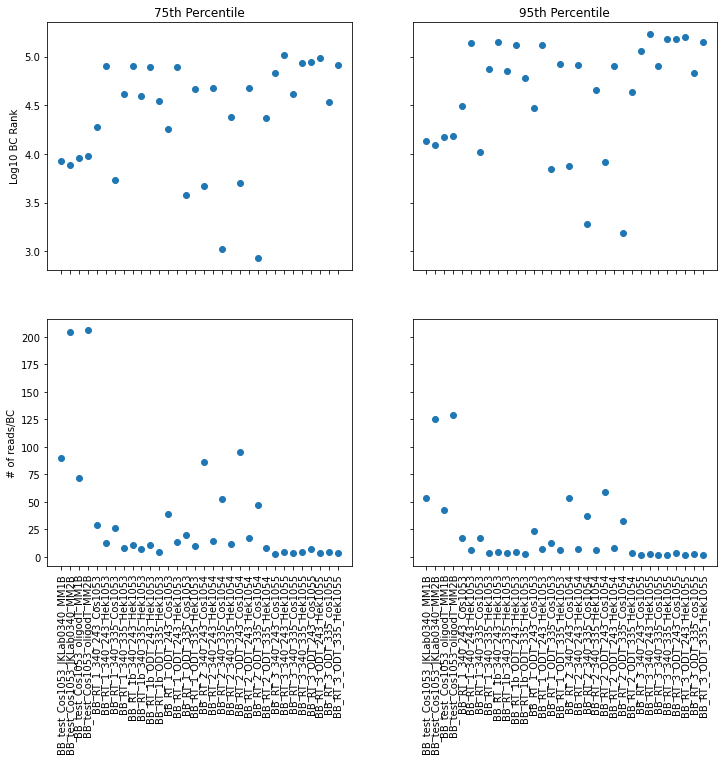

In [108]:
sp.plot_waterfall_bysamp( read_cut_filt )

In [109]:
read_cut_filt.to_csv( bdout + 'n_bcs_passfilt_bysamp.2022-0926.txt',
                        sep = '\t',
                        index = False )

In [110]:
%%time
bybcvartbl_long = { lib: mbcs.combine_rep_perbctbls_long( [ msamp_varbcrnatbl_flen_rename[ lib ][ samp ] for samp in msamp_varbcrnatbl_flen_rename[ lib ] ],
                                                          [ samp for samp in msamp_varbcrnatbl_flen_rename[ lib ] ] )
                    for lib in msamp_varbcrnatbl_flen_rename }

CPU times: user 1.66 s, sys: 778 ms, total: 2.44 s
Wall time: 2.43 s


In [111]:
bybcvartbl_long[ 'JKP1053' ]

,sample,passes,refname,status,n_variants_passing,variant_list,max_altAF,second_altAF,max_altRD,second_altRD,...,soft_clipped,other_isoform,KTS+,KTS-,SKIP,OTHER,KTS+_psi,KTS-_psi,SKIP_psi,OTHER_psi
barcode,,,,,,,,,,,,,,,,,,,,,
TGAGTTGGGCGCCTAATTGGTGG,BB_test_Cos1053_JKLab0340_MM1B,True,jkp815,no_variants_input,0,NaN,-1.000000,-1.0,-1,-1,...,0,0,0,28,2,0,0.000000,0.933333,0.066667,0.0
TGAGTTTACTCTGTAGGGTTTGG,BB_test_Cos1053_JKLab0340_MM1B,True,jkp815,no_variants_input,0,NaN,-1.000000,-1.0,-1,-1,...,0,0,147,6,5,0,0.930380,0.037975,0.031646,0.0
TGAGTTTGGGGGAGCACGTTTGG,BB_test_Cos1053_JKLab0340_MM1B,True,jkp815,no_variants_input,0,NaN,-1.000000,-1.0,-1,-1,...,0,0,1,69,5,0,0.013333,0.920000,0.066667,0.0
TGAGTTATGATTGTAGCTGATGG,BB_test_Cos1053_JKLab0340_MM1B,True,jkp815,pass,1,jkp815:1231:G:C,0.634021,-1.0,123,-1,...,0,1,106,1,6,0,0.938053,0.008850,0.053097,0.0
TGAGTTTCGTCTTTTTCAATTGG,BB_test_Cos1053_JKLab0340_MM1B,True,jkp815,apparently_wt_no_passing_vars,0,NaN,1.000000,-1.0,2,-1,...,0,0,59,1,0,0,0.983333,0.016667,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATTGTTAATCTCTTTTGATCTGG,BB_RT_1_ODT_335_Hek1053,True,jkp815,no_variants_input,0,NaN,-1.000000,-1.0,-1,-1,...,0,0,0,0,6,0,0.000000,0.000000,1.000000,0.0
ATTGTGTATGGCACCGTATTTGG,BB_RT_1_ODT_335_Hek1053,True,jkp815,no_variants_input,0,NaN,-1.000000,-1.0,-1,-1,...,0,0,0,3,0,0,0.000000,1.000000,0.000000,0.0
ATTGTGTACGTGGACGGCTATGG,BB_RT_1_ODT_335_Hek1053,True,jkp815,no_variants_input,0,NaN,-1.000000,-1.0,-1,-1,...,0,0,0,1,1,0,0.000000,0.500000,0.500000,0.0


In [112]:
for lib in satbl_fn:
    
    bybcvartbl_long[ lib ].to_csv( bdout + 'wt1_ex9_%s_by_bc_effects_allvars-2022-0926.txt' % lib,
                                    sep='\t'
                                 )

In [115]:
msamp_byvartbl_allisos_snvs = { lib: { samp: mbcs.filter_byvartbl_snvonly( msamp_bcs_processed[ lib ][ samp ][ 'msamp_byvartbl_allisos' ] )
                                        for samp in msamp_bcs_processed[ lib ] }
                                for lib in msamp_bcs_processed }

In [116]:
msamp_byvartbl_allisos_snvs[ 'JKP1053' ][ 'BB_test_Cos1053_JKLab0340_MM1B' ].head() 

,varlist,chrom,pos,ref,alt,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,sum_usable_reads,...,per_bc_passfilt,per_reads_passfilt,per_usable_reads,per_unmapped_reads,per_secondary_reads,per_unpaired_reads,per_bad_starts,per_bad_ends,per_soft_clipped,per_other_isoform
1,jkp815:1140:A:G,jkp815,1140,A,G,1,1,200,200,199,...,100.000000,100.000000,99.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0
2,jkp815:1148:G:C,jkp815,1148,G,C,1,1,78,78,78,...,100.000000,100.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,jkp815:1167:C:T,jkp815,1167,C,T,1,0,2,0,0,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,jkp815:1175:G:A,jkp815,1175,G,A,1,0,20,0,0,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,jkp815:1189:G:A,jkp815,1189,G,A,3,2,178,173,173,...,66.666667,97.191011,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
for lib in msamp_byvartbl_allisos_snvs:

    for samp in msamp_byvartbl_allisos_snvs[ lib ]:

        msamp_byvartbl_allisos_snvs[ lib ][ samp ][ 'hgvs_pos' ] = cds.pos_to_hgvspos( msamp_byvartbl_allisos_snvs[ lib ][ samp ].pos,
                                                                                        ( 1058, 1554 ),
                                                                                        [ (1267, 1359) ],
                                                                                        [ ( 1355, 1447 ), ]
                                                                                     )

In [118]:
lib_byvartbl_allisos_long = { lib: mbcs.combine_allisos_pervartbls_long( [ msamp_byvartbl_allisos_snvs[ lib ][ samp ] for samp in msamp_byvartbl_allisos_snvs[ lib ] ],
                                                                      [ samp for samp in msamp_byvartbl_allisos_snvs[ lib ] ] )
                              for lib in msamp_byvartbl_allisos_snvs } 

In [119]:
for lib in lib_byvartbl_allisos_long:
    
    lib_byvartbl_allisos_long[ lib ].to_csv( bdout + 'wt1_ex9_%s_by_var_effects_allisos_snvs-2022-0926.txt' % lib,
                                              sep = '\t',
                                              index = False
                                            )

In [120]:
byvartbl_allisos_long = pd.concat( [ lib_byvartbl_allisos_long[ lib ] for lib in lib_byvartbl_allisos_long ] )

In [121]:
byvartbl_allisos_long

,chrom,pos,ref,alt,varlist,sample,wmean_iso5642,median_iso1919,mean_iso5619,wmean_iso5537,...,median_iso6586,wmean_iso4729,wmean_iso3348,wmean_iso3022,median_iso2787,wmean_iso4720,mean_iso1074,wmean_iso4840,median_iso1996,mean_iso6806
0,jkp815,1140,A,G,jkp815:1140:A:G,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,...,0.0,0.035176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,jkp815,1148,G,C,jkp815:1148:G:C,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,...,0.0,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,jkp815,1167,C,T,jkp815:1167:C:T,BB_test_Cos1053_JKLab0340_MM1B,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,jkp815,1175,G,A,jkp815:1175:G:A,BB_test_Cos1053_JKLab0340_MM1B,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,jkp815,1189,G,A,jkp815:1189:G:A,BB_test_Cos1053_JKLab0340_MM1B,0.0,0.0,0.0,0.0,...,0.0,0.011561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4663,jkp815,1398,T,C,jkp815:1398:T:C,BB_RT_3_ODT_335_Hek1055,0.0,0.0,0.0,0.0,...,0.0,0.158730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4664,jkp815,1398,T,G,jkp815:1398:T:G,BB_RT_3_ODT_335_Hek1055,0.0,0.0,0.0,0.0,...,0.0,0.213592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4665,jkp815,1399,T,A,jkp815:1399:T:A,BB_RT_3_ODT_335_Hek1055,0.0,0.0,0.0,0.0,...,0.0,0.424051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4666,jkp815,1399,T,C,jkp815:1399:T:C,BB_RT_3_ODT_335_Hek1055,0.0,0.0,0.0,0.0,...,0.0,0.236364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
byvartbl_allisos_long.to_csv( bdout + 'wt1_ex9_by_var_effects_allisos_snvs-2022-0926.txt',
                                              sep = '\t',
                                              index = False
                                            )

In [123]:
%%time
msamp_byvartbl = { lib: { samp: mbcs.summarize_byvar_singlevaronly_pe( satbl_fn[ lib ],
                                                                       msamp_bcs_processed[ lib ][ samp ][ 'msamp_bcrnatbl_rename' ],
                                                                      cut_dict[ samp ],
                                                                     [ 'secondary_reads', 'unpaired_reads', 'unmapped_reads', 'bad_starts', 'bad_ends', 'soft_clipped', 'other_isoform', 'usable_reads', ],
                                                                     [ 'KTS+', 'KTS-', 'SKIP', 'OTHER' ] )
                           for samp in msamp_bcs_processed[ lib ] }
                 for lib in msamp_bcs_processed } 

CPU times: user 1min 51s, sys: 1.15 s, total: 1min 52s
Wall time: 1min 52s


In [124]:
msamp_byvartbl_snvs = { lib: { samp: mbcs.filter_byvartbl_snvonly( msamp_byvartbl[ lib ][ samp ] )
                                  for samp in msamp_byvartbl[ lib ] }
                        for lib in msamp_byvartbl }

In [125]:
for lib in msamp_byvartbl_snvs:

    for samp in msamp_byvartbl_snvs[ lib ]:

        msamp_byvartbl_snvs[ lib ][ samp ][ 'hgvs_pos' ] = cds.pos_to_hgvspos( msamp_byvartbl_snvs[ lib ][ samp ].pos,
                                                                               ( 1058, 1554 ),
                                                                                [ (1267, 1359) ],
                                                                                [ ( 1355, 1447 ), ]
                                                                              )

In [126]:
#last bp of exon is 32413518
#first bp of exon is 32413610
for lib in msamp_byvartbl_snvs:

    for samp in msamp_byvartbl_snvs[ lib ]:

        msamp_byvartbl_snvs[ lib ][ samp ][ 'hg19_pos' ] = cds.vpos_to_gpos( msamp_byvartbl_snvs[ lib ][ samp ].pos,
                                                                              ( 1058, 1554 ),
                                                                              [ 32413323, 32413819 ] ,
                                                                              rev_strand = True
                                                                             )

In [127]:
lib_byvartbl_long = { lib: mbcs.combine_rep_pervartbls_long( [ msamp_byvartbl_snvs[ lib ][ samp ] for samp in msamp_byvartbl_snvs[ lib ] ],
                                                              [ samp for samp in msamp_byvartbl_snvs[ lib ] ] )
                      for lib in msamp_byvartbl_snvs }

In [128]:
for lib in lib_byvartbl_long:

    lib_byvartbl_long[ lib ].to_csv( bdout + 'wt1_ex9_%s_by_var_effects_snvs-2022-0926.txt' % lib,
                                      sep = '\t',
                                      index = False )

In [129]:
lib_byvartbl_long[ 'JKP1053' ]

,chrom,pos,ref,alt,varlist,sample,n_bc,n_bc_passfilt,sum_reads,sum_reads_passfilt,...,per_secondary_reads,per_unpaired_reads,per_unmapped_reads,per_bad_starts,per_bad_ends,per_soft_clipped,per_other_isoform,per_usable_reads,hgvs_pos,hg19_pos
0,jkp815,1140,A,G,jkp815:1140:A:G,BB_test_Cos1053_JKLab0340_MM1B,1,1,200,200,...,0.000000,0.0,0.0,0.000000,0.5,0.0,0.0,99.50000,c.1355-127,32413737
1,jkp815,1148,G,C,jkp815:1148:G:C,BB_test_Cos1053_JKLab0340_MM1B,1,1,78,78,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,100.00000,c.1355-119,32413729
2,jkp815,1167,C,T,jkp815:1167:C:T,BB_test_Cos1053_JKLab0340_MM1B,1,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1355-100,32413710
3,jkp815,1175,G,A,jkp815:1175:G:A,BB_test_Cos1053_JKLab0340_MM1B,1,0,20,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1355-92,32413702
4,jkp815,1189,G,A,jkp815:1189:G:A,BB_test_Cos1053_JKLab0340_MM1B,3,2,178,173,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,100.00000,c.1355-78,32413688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9004,jkp815,1398,T,C,jkp815:1398:T:C,BB_RT_1_ODT_335_Hek1053,33,20,349,319,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,100.00000,c.1447+39,32413479
9005,jkp815,1398,T,G,jkp815:1398:T:G,BB_RT_1_ODT_335_Hek1053,67,36,500,416,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,100.00000,c.1447+39,32413479
9006,jkp815,1399,T,A,jkp815:1399:T:A,BB_RT_1_ODT_335_Hek1053,46,20,405,335,...,0.597015,0.0,0.0,0.597015,0.0,0.0,0.0,98.80597,c.1447+40,32413478
9007,jkp815,1399,T,C,jkp815:1399:T:C,BB_RT_1_ODT_335_Hek1053,36,25,452,422,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,100.00000,c.1447+40,32413478


In [130]:
byvartbl_long = pd.concat( [ lib_byvartbl_long[ lib ] for lib in lib_byvartbl_long ] )

In [131]:
byvartbl_long[ 'exon_num' ] = '9'

In [132]:
byvartbl_long[ 'ref_c' ] = byvartbl_long.ref

In [133]:
byvartbl_long[ 'alt_c' ] = byvartbl_long.alt

In [134]:
byvartbl_long[ 'ref' ] = [ css.rev_complement( r ) for r in byvartbl_long.ref_c ]

In [135]:
byvartbl_long[ 'alt' ] = [ css.rev_complement( a ) for a in byvartbl_long.alt_c ]

In [136]:
byvartbl_long.to_csv( bdout + 'wt1_ex9_by_var_effects_snvs-2022-0926.txt',
                      sep = '\t',
                      index = False )